In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm # Colormaps
import pymc3 as pm
import theano.tensor as T
import seaborn as sns
from theano.tensor.nlinalg import matrix_inverse
%matplotlib inline
import arviz as az
from scipy import stats
from functools import reduce
from operator import mul, add
import theano.tensor as tt
import theano
az.style.use('arviz-darkgrid')

# Introduction


WORK ON THIS TEXT AS IT WAS COPIED

https://blog.dominodatalab.com/fitting-gaussian-process-models-python/


What if we choose to use Gaussian distributions to model our data?

$$p(x|\pi,\Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2}\exp{-\frac{1}{2}(x-\mu)'\Sigma^{-1}(x-\mu)}$$

There would not seem to be any gain doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$
\begin{eqnarray*}
p(x,y) & = & \mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_x & \Sigma_{xy}\\
\Sigma_{xy}^T & \Sigma_y
\end{array}\right]\right)
\end{eqnarray*}
$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), \Sigma_x - \Sigma_{xy}\Sigma^{-1}_{y}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an inifinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an inifite vector that inly returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a distribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim GP(m(x), k(x,x'))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$\begin{aligned}
m(x)&=0 \\
k(x, x')&=\eta\exp(-\frac{\ell}{2}(x-x')^2)
\end{aligned}$$

Here, the covariance function is a squared exponential, for which values of $x$ and $x'$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean of the Gaussian process - surely we can do better than that. It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean function and covariance function, respectively, evaluated at those points.


Gaussian processes are non-parametric methods. Instead of inferring a distribution over the parameters of a parametric function, GP can be used to infer a distribution over functions directly. It defines a prior over functions and after having observed some function values it can be converted into a posterior over functions.

A Gaussian process is a random process where any point ${x} \in \mathbb{R}^d$ is assigned a random variable $f({x})$ and where the joint distribution of a finite number of these variables $p(f(x_1),...,f(x_N))$ is itself a Gaussian:

$$p(f|X) = \mathcal{N}(f|\mu,K)$$

where $f=(f(x_1),...,f(x_N)$, $\mu=(m(x_1),...,m(x_N))$ and $K_{ij}=k(x_i,x_j)$. $m$ is the mean function and GPs are flexible enough to model the mean arbitrarily well. $k$ is a positive definite kernel function of covariance function. Thus, a Gaussian process is a distirbution over functions whose shape (smoothness,...) is defined by $K$. If points $x_i$ and $x_j$ are considered to be similar by the kernel the function values at these points, $f(x_i)$ and $f(x_j)$ can be expected to be similar too.

Given a training dataset with noise-free function values $f$ at inputs $X$, a GP prior can be converted into a GP posterior $p(f_*|X_*, X, f)$ which can then be used to make predictions $f_*$ at new inputs $X_*$. By definiton of a GP, the joint distribution of observed values $f$ and $f_*$ is again a Gaussian which can be partioned into

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K_*^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$

where $K_*=k(X, X_*)$ and $K_{**}=k(X_*,X_*)$. With $N$ training data and $N_*$ new input data $K$ is a $N$x$N$ matrix, $K_*$ a $N$x$N_*$ matrix and $K_{**}$ a $N_*$x$N_{*}$ matrix. Using standard rules for conditioning Gaussians, the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

If we have a training dataset with noisy function values $y = f + \epsilon$, where noise is $\epsilon \sim \mathcal{N}(0, \sigma^2_yI)$ is independently added to each observation then the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK_y^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK_y^{-1}K_*
\end{aligned}$$

where $K_y = K + \sigma_y^2I$. Although the equation above covers noise in the training data, it is still a distribution over noise-free predictions $f_*$. To additionally include noise $\epsilon$ into predictions $y_*$ we have to add $\sigma_y^2$ to the diagonal of $\Sigma_*$

$$p(y_*|X_*, X, y) = \mathcal{N}(y_*|\mu_*, \Sigma_* + \sigma_y^2I)$$

In [768]:
import numpy as np

def kernel(x1, x2, l=1.0, η=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        x1: Array of m points (m x d)
        x2: Array of n points (n x d)
        
    Returns:
        (m x n) matrix
    """
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return η**2 * np.exp(-0.5 / l**2 * sqdist)

# Multivariate Normal

WORK ON THIS TEXT AND CODE AS IT WAS COPIED

https://peterroelants.github.io/posts/multivariate-normal-primer/

The multivariate normal distribution is a multidimensional generalization of the one-dimensional normal distribution. It represents the distribution of a multivariate random variable that is made up of multiple random variables that can be correlated with each other.

Like the normal distribution, the multivariate normal is defined by sets of parameters: the man vector $\mu$, which is the expected value of the distribution and the covariance matrix $\Sigma$, which measures how dependent two random variables are and how they change together.

The multivariate normal with dimensionality $d$ has a joint probability density given by:

$$p(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}\exp\big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big)$$

where $x$ is a random vector of size $d$, $\mu$ is the mean vector $\Sigma$ is the symmetric and positive definite covariance matrix (of size $d$x$d$) and $|\Sigma|$ is the determinant. We denote this multivariate normal distribution as:

$$\mathcal{N}(\mu, \Sigma)$$

In [769]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal dist"""
    x_m = x - mean
    return (1. / (np.sqrt((2*np.pi)**d * np.linalg.det(covariance))) 
            * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m))/2))

Examples of two bivariate normal distributions are plotted below.

The figure on the left is a bivariate distribution with the covariance between $x_1$ and $x_2$ set to 0 so that these two variables are independent.

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right]\right)
\end{eqnarray*}$$


The figure on the right is a bivariate distribution with the covariance between $x_1$ and $x_2$ set to different than 0 so that these two variables are dependent.



$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
1
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$


In [770]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

<ipython-input-771-7c8c82ce4a15>:36: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(right=0.8)


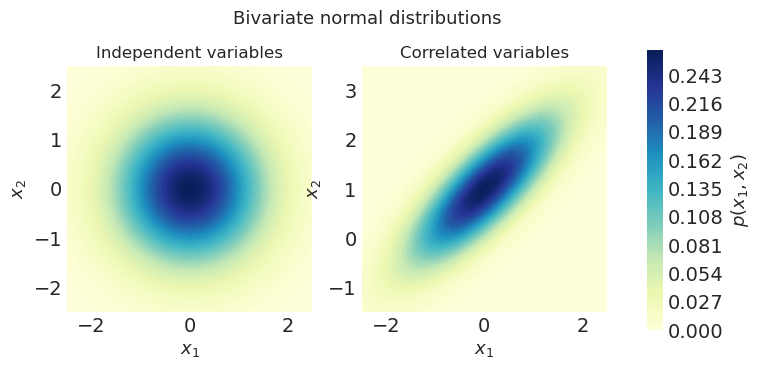

In [771]:
# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

# Sampling from a multivariate normal

##### Affine transformations of the multivariate normal

It is possible to transform as multivariate normal distribution into a new normal distribution with an affine transformation. More specifically if $X$ is normally distributed and $Y=LX + u$ with $L$ a linear transformation and $u$ a vector then $Y$ is also normally distributed with mean $\mu_Y = u + L\mu_x$ and covariance matrix $\Sigma_Y = L\Sigma_XL^T$.

$$\begin{aligned}
Y &\sim \mathcal{N}(\mu_Y, \Sigma_Y) & X \sim \mathcal{N}(\mu_X, \Sigma_X)
\end{aligned}$$

$$\mathcal{N}(\mu_Y, \Sigma_Y) = \mathcal{N}(u + L\mu_X, L\Sigma_XL^T) = L\mathcal{N}(\mu_x, \Sigma_X)+ u$$

##### Sampling

The previous formula helps us to sample from any multivariate gaussian. To do the sampling we can sample $X$ from the standard normal distribution $X \sim \mathcal{N}(0, I_d)$, where the mean is the vector $\mu = 0$ and the covariance is the identity matrix $\Sigma = I_d$. Sampling from this distribution is easier because each variable in $X$ is independent from all other variables, we can just sample each variable separately.

It is then possible to sample $Y$ from $\mathcal{N}(\mu_Y, \Sigma_Y)$ by sampling $X$ and applying the affine transform on the samples. This transform is $Y = LX + u$ where we know from the previous sections that the covariance of $Y$ will be $\Sigma_Y = L\Sigma_XL^T$. Since $\Sigma_X = I_d$ we can write that $\Sigma_Y = LI_dL^T=LL^T$.

$L$ can now be found by a technique called Cholesky decomposition which does exactly the decomposition we need. The vector $u$ is then $\mu_Y$ since $\mu_X=0$ ($u=\mu_Y-L\mu_X$).

Let's try this out by sampling 50 samples from:

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
1
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$

The sampling is done by the following code and the samples are plotted as red dots on the probability density surface below. 


In [772]:
# Sample from:
d = 2 # number of dimensions

mean = np.matrix([[0.], [1.]])
covariance = np.matrix([
    [1, 0.8],
    [0.8, 1.]
])

# Create L
L = np.linalg.cholesky(covariance)
print(L)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

[[1.  0. ]
 [0.8 0.6]]


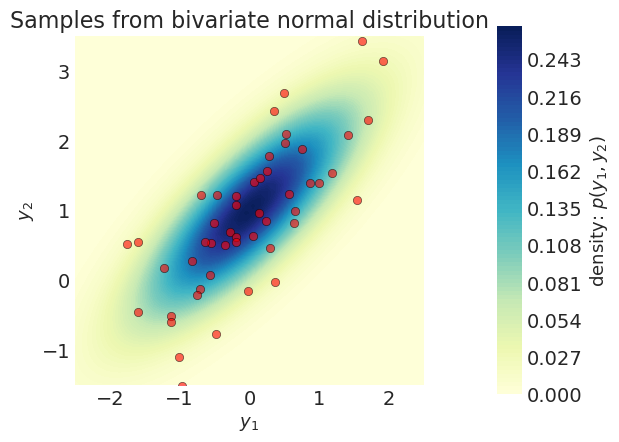

In [773]:
# Plot the samples and the distribution
fig, ax = plt.subplots(figsize=(6, 4.5))
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot samples
ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')
ax.set_title('Samples from bivariate normal distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=13)
plt.show()
#

# Time to play around with sampling

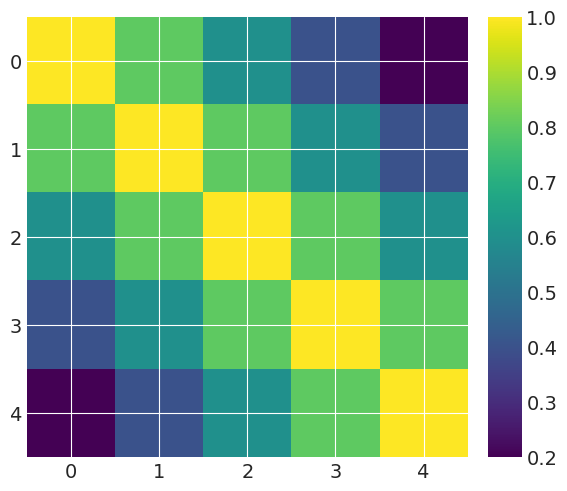

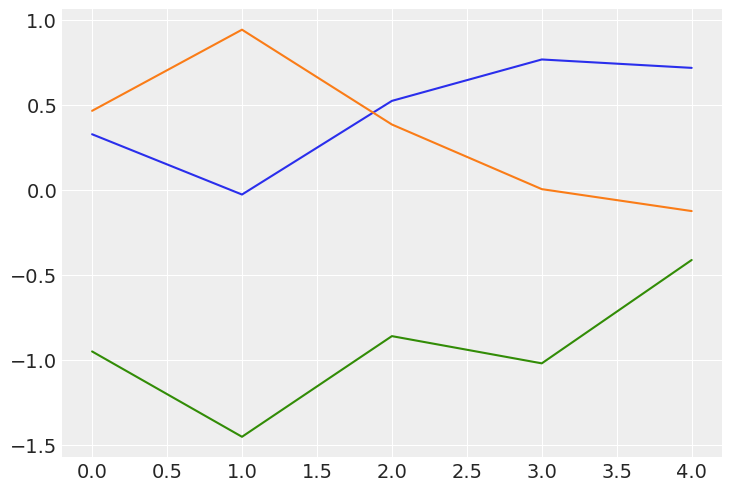

In [774]:
# Sample from:
d = 5 # number of dimensions

mean = np.zeros((d,1))
covariance = np.matrix([
    [1, 0.8, 0.6, 0.4, 0.2],
    [0.8, 1., 0.8, 0.6, 0.4],
    [0.6, 0.8, 1., 0.8, 0.6],
    [0.4, 0.6, 0.8, 1., 0.8],
    [0.2, 0.4, 0.6, 0.8, 1.],
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=3 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y);

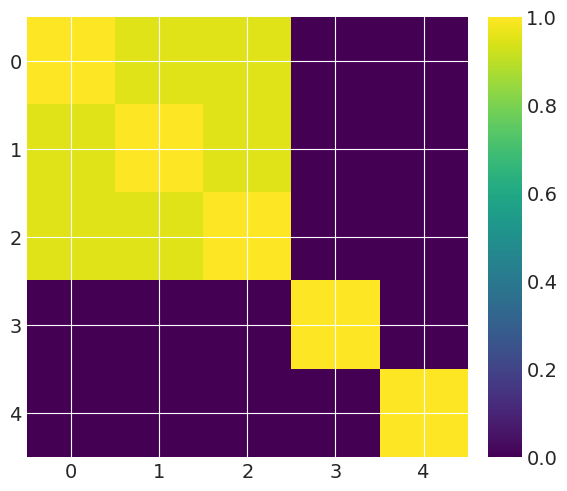

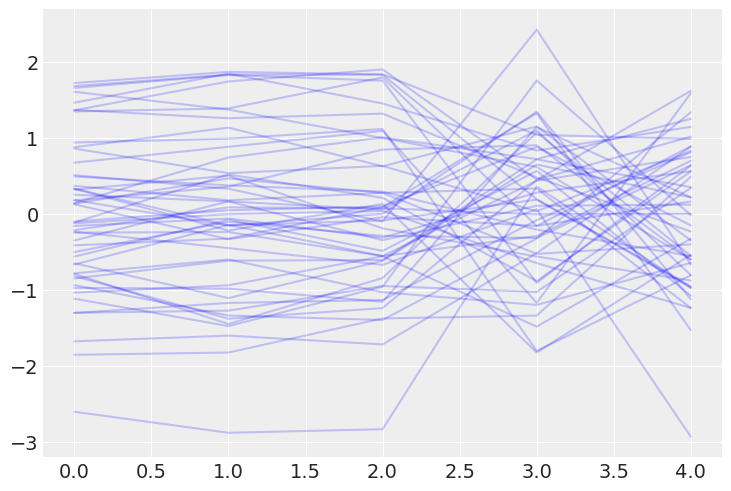

In [775]:
# Sample from:
d = 5 # number of dimensions

mean = np.array([[0.],
               [0.],
               [0.],
               [0.],
               [0.]])
covariance = np.matrix([
    [1, 0.95, 0.95, 0., 0.],
    [0.95, 1., 0.95, 0., 0.],
    [0.95, 0.95, 1., 0., 0.],
    [0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 1.],
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y, color='b', alpha=0.2);

We can see that the first three points are highly correlated and the remaining points are independent of the first points and between themselves.

Before moving on, let's talk about positive definite matrices.

We need to understand if our covariance matrix is positive definite. For that there are two tests that we can do, first is to ensure that our matrix is symmetric and the second that $z^TMz$ is strictly positive for every non-zero vector $z$ (read more here [[*2*]](https://en.wikipedia.org/wiki/Definite_symmetric_matrix#Cholesky_decomposition)). We can use a Cholesky decomposition $M=LL^*$ for the latter. It yields the lower triangular matrix $L$, with a positive diagonal.

One way to generate such a matrix is to ensure that it is diagonally dominant. For that we can

$$M^TM + cI$$

where $c$ is just a constant that we will sum to the diagonal of the matrix. This makes the eigenvalues of the matrix >= $c$.

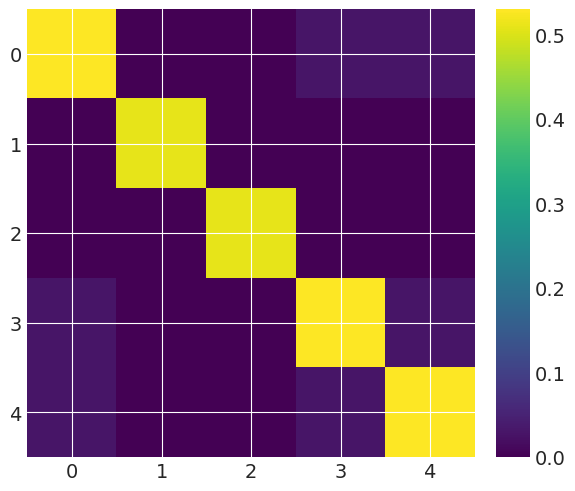

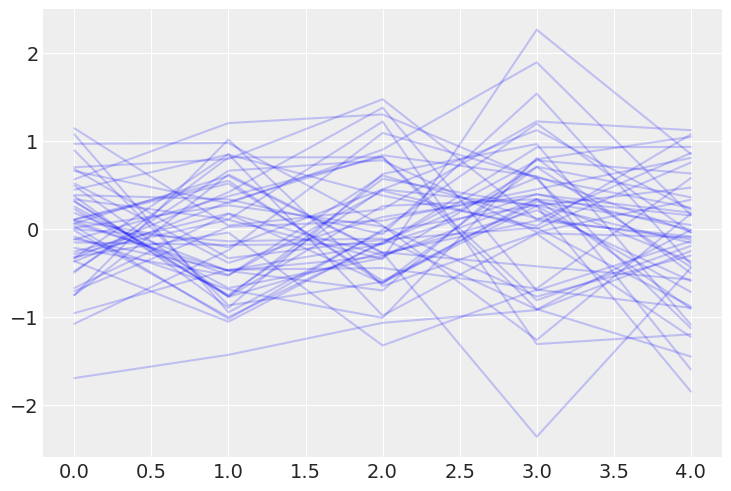

In [776]:
# Sample from:
d = 5 # number of dimensions

mean = np.array([[0.],
               [0.],
               [0.],
               [0.],
               [0.]])
covariance = np.matrix([
    [0.1, 0., 0., 0.1, 0.1],
    [0., 0.1, 0., 0., 0.],
    [0., 0., 0.1, 0., 0.],
    [0.1, 0., 0., 0.1, 0.1],
    [0.1, 0., 0., 0.1, 0.1],
])

covariance = covariance.T*covariance + 0.5*np.eye(covariance.shape[0])
# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y, color='b', alpha=0.2);

First, fourth and fifth point are highly correlated while the remains are not correlated between themselves of with any of the other points. 

These are all prior realizations of a Gaussian Process.

To finalize this analysis, let's understand what conditioning on new points does to our matrix. In this case let's imagine that we were conditioning on the $4^{th}$ point and considering a small bit of noise. Notice how that is represented on our matrix and how sampling using this matrix gives us.

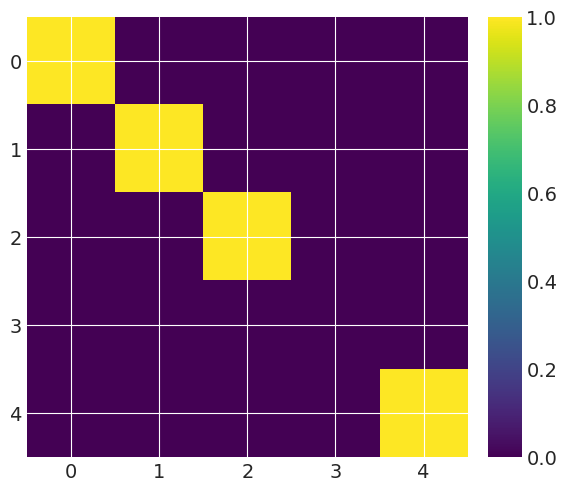

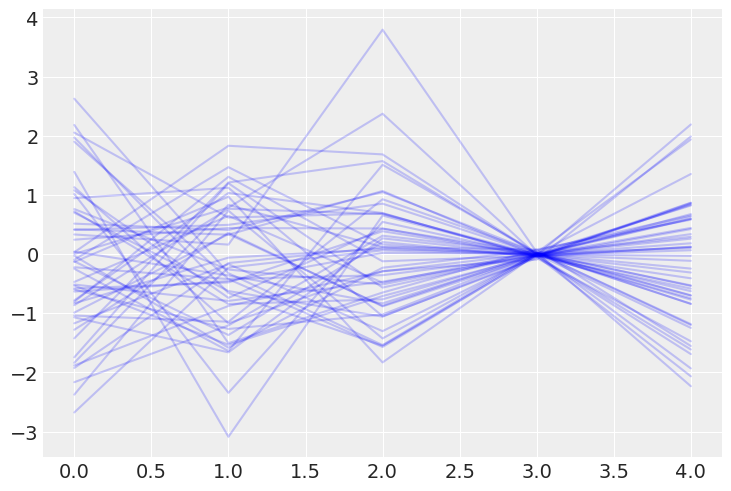

In [777]:
# Sample from:
d = 5 # number of dimensions

mean = np.array([[0.],
               [0.],
               [0.],
               [0.],
               [0.]])
covariance = np.matrix([
    [1., 0., 0., 0.0, 0.0],
    [0., 1., 0., 0., 0.],
    [0., 0., 1., 0., 0.],
    [0.0, 0., 0., 0.001, 0.0],
    [0.0, 0., 0., 0.0, 1.],
])

#covariance = covariance.T*covariance + 0.5*np.eye(covariance.shape[0])
# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y, color='b', alpha=0.2);

All the samples happen to funnel at this point, really approximating the value that we are conditioning on. We just add a very small value to ensure that the matrix is positive definite, you can image this as a very small noise parameter added to the model. Nevertheless, the uncertainty around that point is virtually non-existent.

# Prior

Let's first define a prior over functions with mean zero and covariance matrix computed with the kernel defined above. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

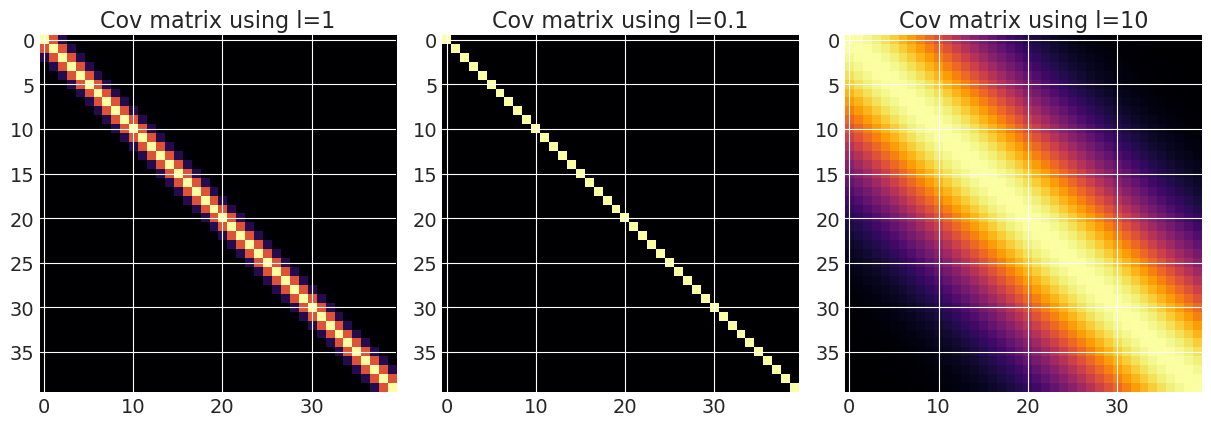

In [778]:
# Finite number of points
X = np.arange(-20, 20, 1).reshape(-1, 1)

params = [1, 0.1, 10]
# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov1 = kernel(X, X, l=params[0])

# Draw three samples from the prior
samples1 = np.random.multivariate_normal(mu.ravel(), cov1, 3)
cov2 = kernel(X, X, l=params[1])
cov3 = kernel(X, X, l=params[2])

# Draw three samples from the prior
samples2 = np.random.multivariate_normal(mu.ravel(), cov2, 3)
samples3 = np.random.multivariate_normal(mu.ravel(), cov3, 3)

samples1 = np.tile(samples1, (1, 1, 1))
samples2 = np.tile(samples2, (1, 1, 1))
samples3 = np.tile(samples3, (1, 1, 1))
samples =  np.concatenate((samples1, samples2, samples3), axis=0)

cov1 = np.tile(cov1, (1, 1, 1))
cov2 = np.tile(cov2, (1, 1, 1))
cov3 = np.tile(cov3, (1, 1, 1))
cov =  np.concatenate((cov1, cov2, cov3), axis=0)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

for idx, i in enumerate(params):
    ax[idx].imshow(cov[idx,:,:], cmap="inferno", interpolation='none')
    ax[idx].set_title(f'Cov matrix using l={i}')

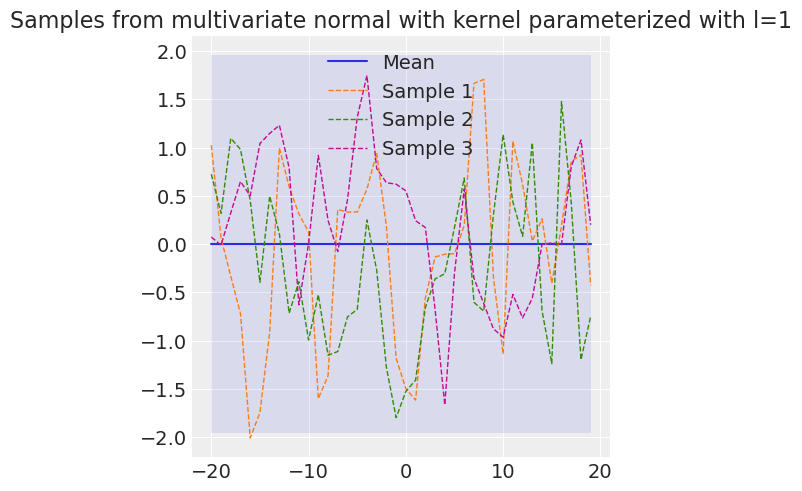

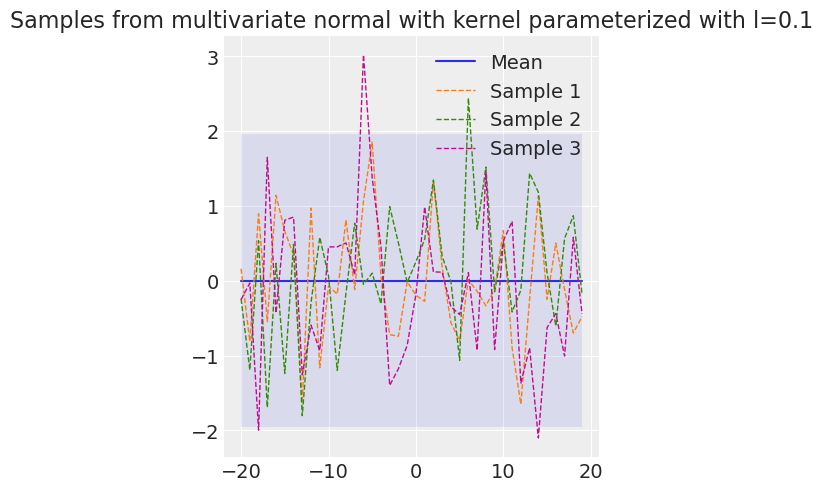

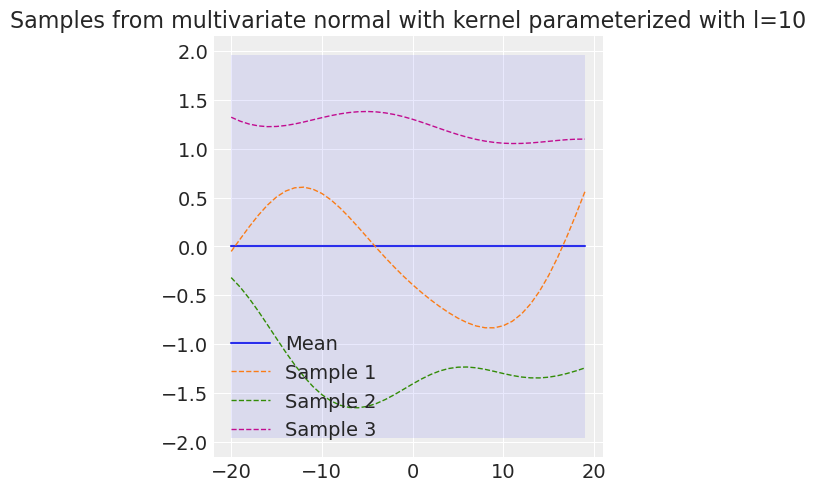

In [779]:
# Plot GP mean, confidence interval and samples 

def plot_gp(mu, cov, X, X_train=None, f=None, samples=[], title=''):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, f, 'rx')
    plt.legend()
    plt.title(title)
    
# Plot GP mean, confidence interval and samples 
for i in range(3):
    plot_gp(mu, cov[i,:,:], X, samples=samples[i,:,:], title=f'Samples from multivariate normal with kernel parameterized with l={params[i]}')
    plt.show()

In [780]:
f = samples[0,:]

# Conditioning to predict

Remember that by definiton of a GP, the joint distribution of observed values $f$ and $f_*$ is again a Gaussian,

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K_*^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$


$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

In [781]:
from numpy.linalg import inv

def posterior(X_s, X_train, f, l=1.0, η=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        f: Training targets (m x 1).
        l: Kernel length parameter.
        η: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, η) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, η)
    K_ss = kernel(X_s, X_s, l, η) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(f)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

The following example draws three samples from the posterior and plots them along with the mean, confidence interval and training data. In a noise-free model, variance at the training points is zero and all random functions drawn from the posterior go through the traning points.

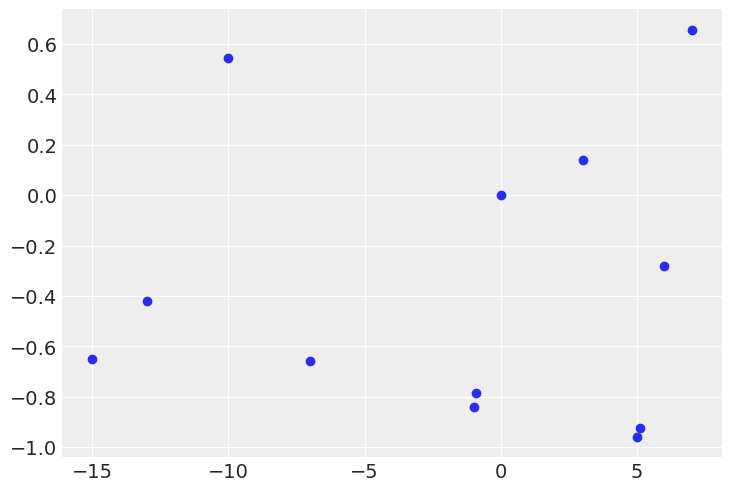

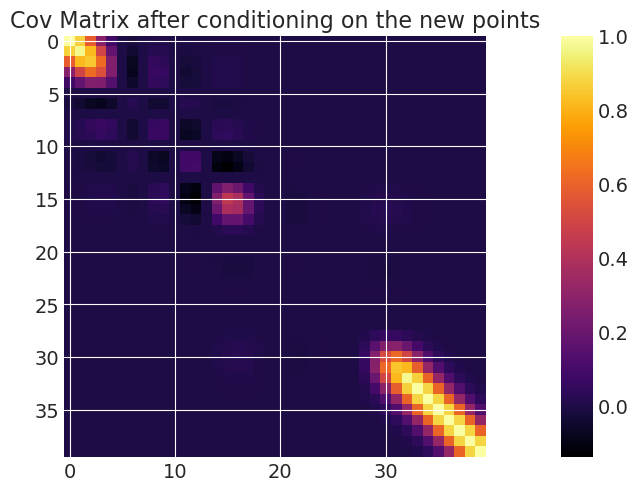

In [782]:
# Noise free training data
X_train = np.array([-15,-13,-10, -7,0, -1, -0.9,3,5, 5.1,6,7]).reshape(-1,1)
f = np.sin(X_train)

# Compute the mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, f, l=2, η=1, sigma_y=1e-8)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

# Plot training data
plt.scatter(X_train, f)
plt.show()

m = plt.imshow(cov_s, cmap="inferno", interpolation='none')
plt.colorbar(m);
plt.title('Cov Matrix after conditioning on the new points')
plt.show()

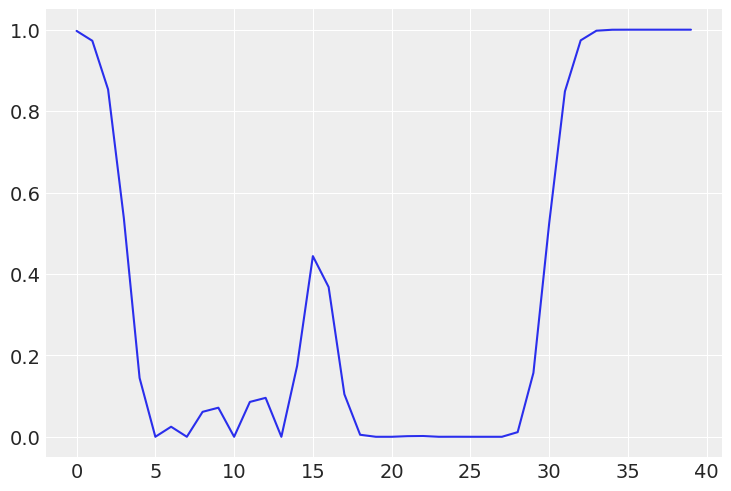

In [783]:
plt.plot(np.diag(cov_s));

Notice that the diagonal is now very different from what we've seen before. Where our new points are located we can find 0 values in the matrix, which makes our multivariate normal realization pass by those points and, at the same time, reduces the uncertainty in the exact point to zero (because we are not considering any noise) and around that point.

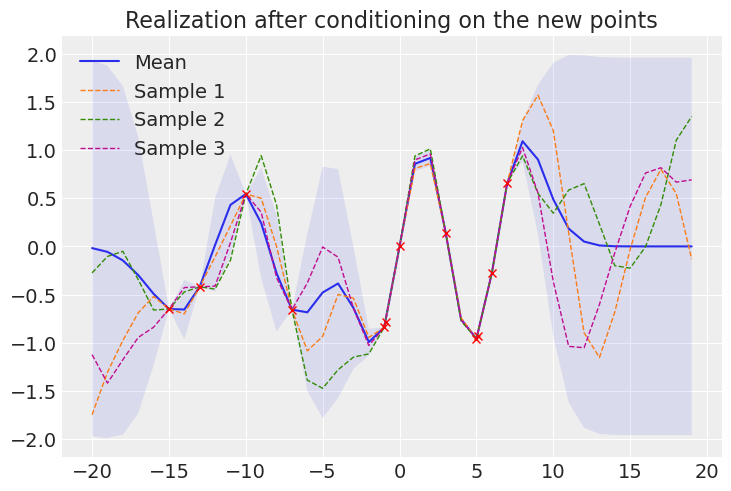

In [784]:
plot_gp(mu_s, cov_s, X, X_train=X_train, f = f, samples=samples)
plt.title('Realization after conditioning on the new points');

If we add a small amount of noise to our new observations we increase the uncertainty around these points.

In [785]:
mu_s, cov_s = posterior(X, X_train, f, l=2, η=1, sigma_y=0.2)

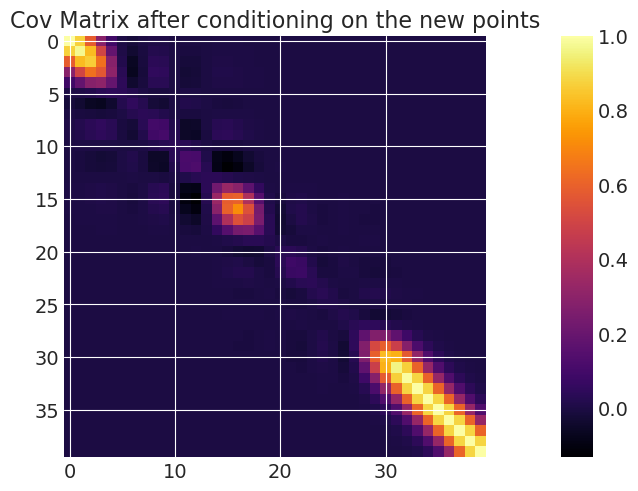

In [786]:

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

m = plt.imshow(cov_s, cmap="inferno", interpolation='none')
plt.colorbar(m)
plt.title('Cov Matrix after conditioning on the new points')
plt.show()

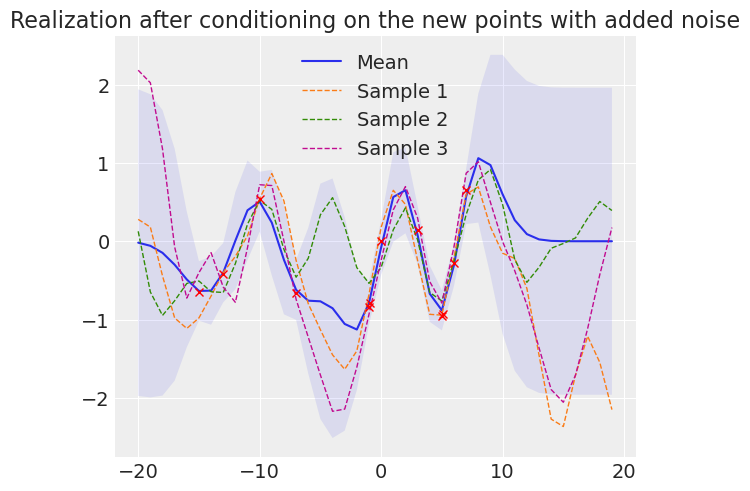

In [787]:
plot_gp(mu_s, cov_s, X, X_train=X_train, f = f, samples=samples)
plt.title('Realization after conditioning on the new points with added noise');

We can see that our samples are not passing through the new points but, instead, are approximating them. Also, the uncertainty is lower than where we don't have points, but it is not zero anymore.

# Using PyMC3

https://docs.pymc.io/notebooks/gaussian_process.html

In [788]:
x = np.linspace(-5, 5)
y = np.sin(x) + np.random.normal(0, 0.2, size=x.shape)

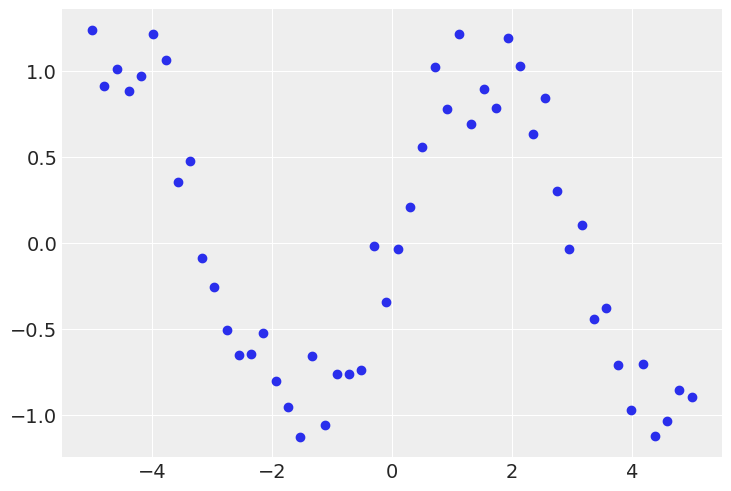

In [789]:
plt.scatter(x,y);

In [761]:
squared_distance = lambda x, y: np.array([[(x.ravel()[i] - y.ravel()[j])**2 for i in range(len(x))] for j in range(len(y))])


with pm.Model() as gp:

    μ = np.zeros(x.shape[0])

    η = pm.HalfCauchy('η', 5)
    ℓ = pm.HalfCauchy('ℓ', 5)
    σ = pm.HalfCauchy('σ', 5)

    # Squared exponential
    D = squared_distance(x, x)
    Σ = T.fill_diagonal(η * T.exp(-ℓ *D), η + σ)

    obs = pm.MvNormal('obs', μ, Σ, observed=y)

Let's check our initial covariance matrix.

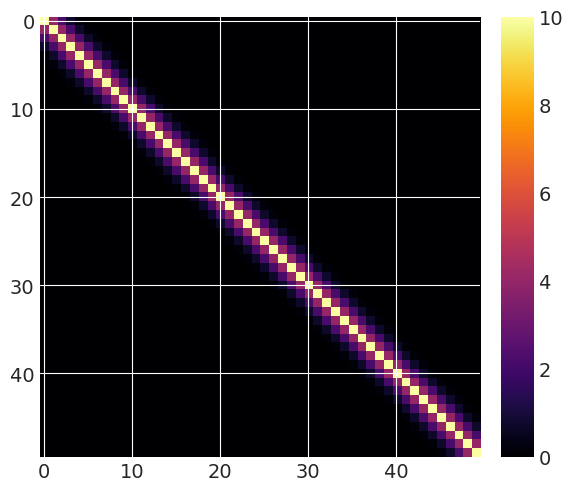

In [762]:
m = plt.imshow(Σ.tag.test_value, cmap="inferno", interpolation='none')
plt.colorbar(m);

The similarity yield by this kernel decreases exponentially with the distance, and that is why we see this pattern around the diagonal.

## Conditioning to predict

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K_*^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$


$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

In [763]:
with gp:

    # Prediction over grid
    X_s = np.linspace(-11, 11)
    D_pred = squared_distance(X_s, X_s)
    D_off_diag = squared_distance(x, X_s)

    # Covariance matrices for prediction
    Σ_pred = η * T.exp(-ℓ * D_pred)
    Σ_off_diag = η * T.exp(-ℓ * D_off_diag)

    # Posterior mean
    μ_post = pm.Deterministic('μ_post', T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    # Posterior covariance
    Σ_post = pm.Deterministic('Σ_post', Σ_pred - T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))

In [764]:
with gp:
    trace = pm.sample(400)

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ℓ, η]


Sampling 4 chains for 1_000 tune and 400 draw iterations (4_000 + 1_600 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


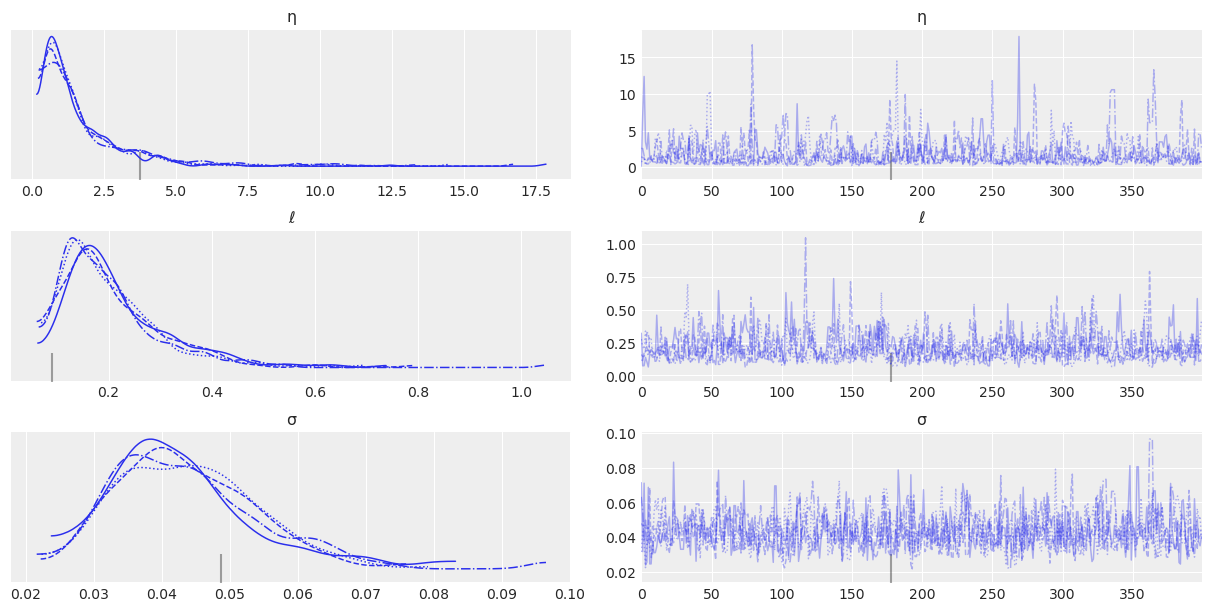

In [765]:
pm.traceplot(trace, var_names=['η', 'ℓ', 'σ']);

In [766]:
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(trace['μ_post'], trace['Σ_post'])]

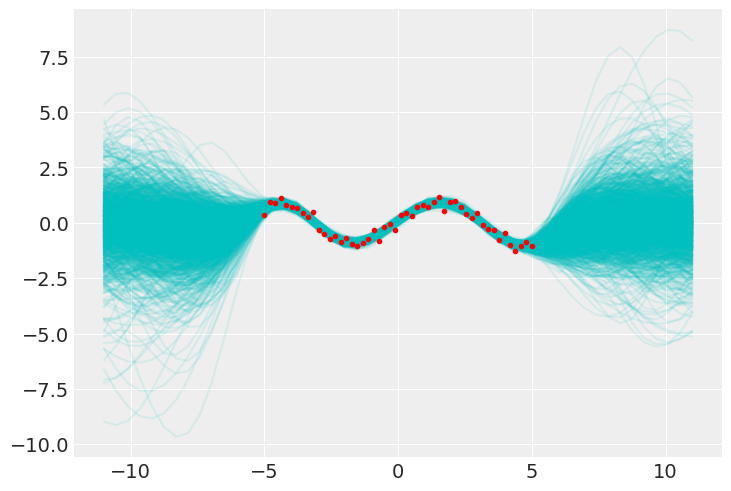

In [767]:
for yp in y_pred:
    plt.plot(np.linspace(-11, 11), yp, 'c-', alpha=0.1);
plt.plot(x, y, 'r.');

# Higher dimensions

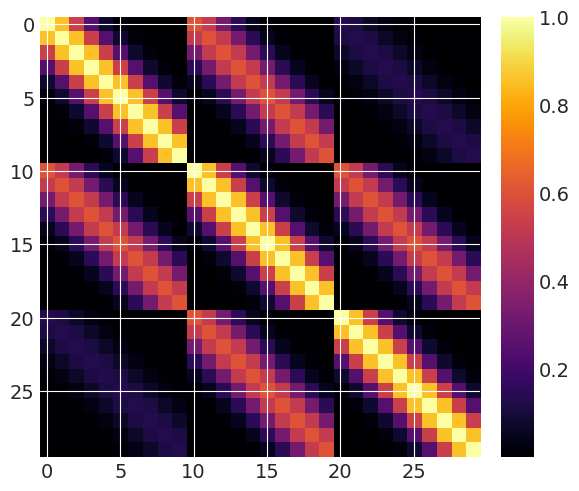

In [17]:
import theano
import theano.tensor as tt


x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

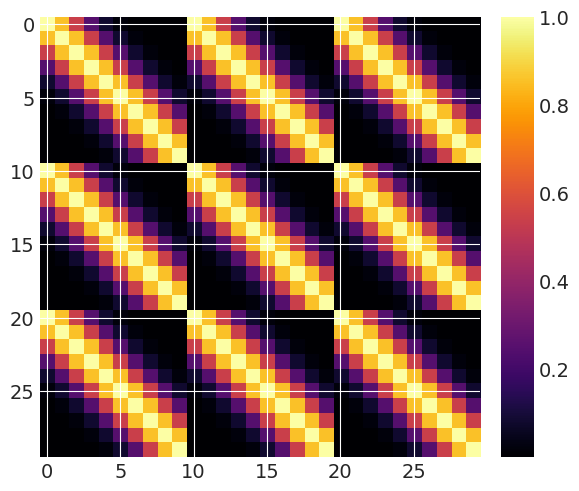

In [18]:
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

In [23]:
class Covariance:
    r"""
    Base class for all kernels/covariance functions.
    Parameters
    ----------
    input_dim: integer
        The number of input dimensions, or columns of X (or Xs)
        the kernel will operate on.
    active_dims: List of integers
        Indicate which dimension or column of X the covariance
        function operates on.
    """

    def __init__(self, input_dim, active_dims=None):
        self.input_dim = input_dim
        if active_dims is None:
            self.active_dims = np.arange(input_dim)
        else:
            self.active_dims = np.asarray(active_dims, np.int)

    def __call__(self, X, Xs=None, diag=False):
        r"""
        Evaluate the kernel/covariance function.
        Parameters
        ----------
        X: The training inputs to the kernel.
        Xs: The optional prediction set of inputs the kernel.
            If Xs is None, Xs = X.
        diag: bool
            Return only the diagonal of the covariance function.
            Default is False.
        """
        if diag:
            return self.diag(X)
        else:
            return self.full(X, Xs)
    
    def _slice(self, X, Xs):
        if self.input_dim != X.shape[-1]:
            warnings.warn(
                f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"
                " being used to compute the covariance function. If this"
                " is not intended, increase 'input_dim' parameter to"
                " the number of columns to use. Ignore otherwise.",
                UserWarning,
            )
        X = tt.as_tensor_variable(X[:, self.active_dims])
        if Xs is not None:
            Xs = tt.as_tensor_variable(Xs[:, self.active_dims])
        return X, Xs

In [24]:
class Stationary(Covariance):
    r"""
    Base class for stationary kernels/covariance functions.
    Parameters
    ----------
    ls: Lengthscale.  If input_dim > 1, a list or array of scalars or PyMC3 random
    variables.  If input_dim == 1, a scalar or PyMC3 random variable.
    ls_inv: Inverse lengthscale.  1 / ls.  One of ls or ls_inv must be provided.
    """

    def __init__(self, input_dim, ls=None, ls_inv=None, active_dims=None):
        super().__init__(input_dim, active_dims)
        if (ls is None and ls_inv is None) or (ls is not None and ls_inv is not None):
            raise ValueError("Only one of 'ls' or 'ls_inv' must be provided")
        elif ls_inv is not None:
            if isinstance(ls_inv, (list, tuple)):
                ls = 1.0 / np.asarray(ls_inv)
            else:
                ls = 1.0 / ls_inv
        self.ls = tt.as_tensor_variable(ls)

    def square_dist(self, X, Xs):
        X = tt.mul(X, 1.0 / self.ls)
        X2 = tt.sum(tt.square(X), 1)
        if Xs is None:
            sqd = -2.0 * tt.dot(X, tt.transpose(X)) + (
                tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))
            )
        else:
            Xs = tt.mul(Xs, 1.0 / self.ls)
            Xs2 = tt.sum(tt.square(Xs), 1)
            sqd = -2.0 * tt.dot(X, tt.transpose(Xs)) + (
                tt.reshape(X2, (-1, 1)) + tt.reshape(Xs2, (1, -1))
            )
        return tt.clip(sqd, 0.0, np.inf)

    def euclidean_dist(self, X, Xs):
        r2 = self.square_dist(X, Xs)
        return tt.sqrt(r2 + 1e-12)

    def diag(self, X):
        return tt.alloc(1.0, X.shape[0])

    def full(self, X, Xs=None):
        raise NotImplementedError

In [25]:
class ExpQuad(Stationary):
    r"""
    The Exponentiated Quadratic kernel.  Also refered to as the Squared
    Exponential, or Radial Basis Function kernel.
    .. math::
       k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]
    """

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs) # Just returns X without any transformation
        return tt.exp(-0.5 * self.square_dist(X, Xs))

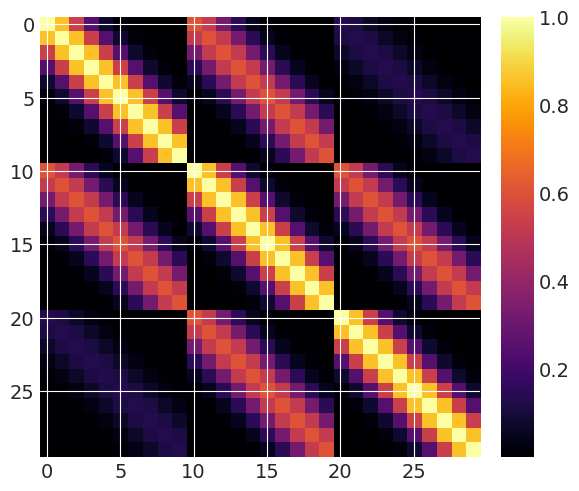

In [118]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

Here we two inputs and we can think of it like coordinates (x,y). We are then calculating the square distance between all points.

In the case of my research on the PhD, we have one of the coordinates referring to the index of the different outpus. This happens because we've flatten our observations and as a consequence we've created a $ns \times ns$ covariance matrix, being $n$ the number of points of each time series and $s$ the number of time series.

We could make the distance between series much further away, for that we just need to use $x_2$.

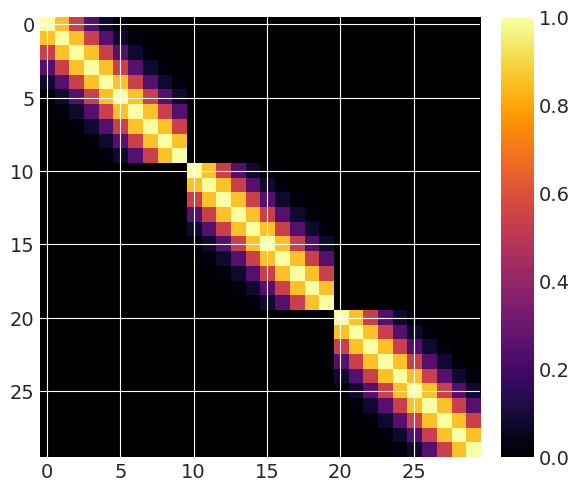

In [119]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.array([0,5,10]))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

In [120]:
# Implementing the ExpQuad for two dimensions

ls = tt.as_tensor_variable(ls)

X = tt.mul(X2, 1.0 / ls)
X2 = tt.sum(tt.square(X), 1)

sqd = -2.0 * tt.dot(X, tt.transpose(X)) + (
        tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))
    )

In [121]:
X.eval()

array([[ 0.        ,  0.        ],
       [ 0.55555556,  0.        ],
       [ 1.11111111,  0.        ],
       [ 1.66666667,  0.        ],
       [ 2.22222222,  0.        ],
       [ 2.77777778,  0.        ],
       [ 3.33333333,  0.        ],
       [ 3.88888889,  0.        ],
       [ 4.44444444,  0.        ],
       [ 5.        ,  0.        ],
       [ 0.        ,  5.        ],
       [ 0.55555556,  5.        ],
       [ 1.11111111,  5.        ],
       [ 1.66666667,  5.        ],
       [ 2.22222222,  5.        ],
       [ 2.77777778,  5.        ],
       [ 3.33333333,  5.        ],
       [ 3.88888889,  5.        ],
       [ 4.44444444,  5.        ],
       [ 5.        ,  5.        ],
       [ 0.        , 10.        ],
       [ 0.55555556, 10.        ],
       [ 1.11111111, 10.        ],
       [ 1.66666667, 10.        ],
       [ 2.22222222, 10.        ],
       [ 2.77777778, 10.        ],
       [ 3.33333333, 10.        ],
       [ 3.88888889, 10.        ],
       [ 4.44444444,

In [122]:
# Square of X and sum of both dimensions
X2.eval().reshape(-1,1)

array([[  0.        ],
       [  0.30864198],
       [  1.2345679 ],
       [  2.77777778],
       [  4.9382716 ],
       [  7.71604938],
       [ 11.11111111],
       [ 15.12345679],
       [ 19.75308642],
       [ 25.        ],
       [ 25.        ],
       [ 25.30864198],
       [ 26.2345679 ],
       [ 27.77777778],
       [ 29.9382716 ],
       [ 32.71604938],
       [ 36.11111111],
       [ 40.12345679],
       [ 44.75308642],
       [ 50.        ],
       [100.        ],
       [100.30864198],
       [101.2345679 ],
       [102.77777778],
       [104.9382716 ],
       [107.71604938],
       [111.11111111],
       [115.12345679],
       [119.75308642],
       [125.        ]])

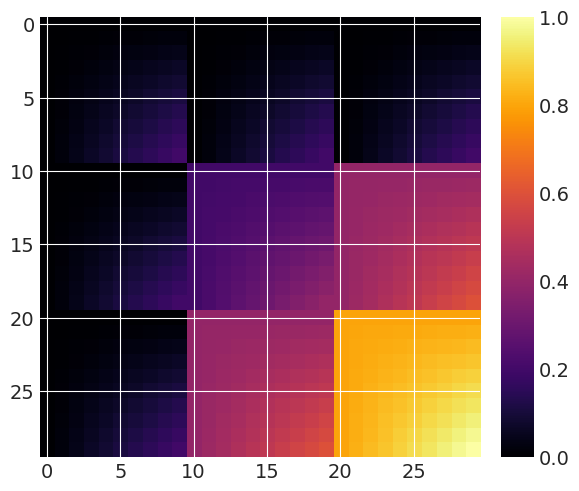

In [123]:
plt.imshow(tt.dot(X, tt.transpose(X)).eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);

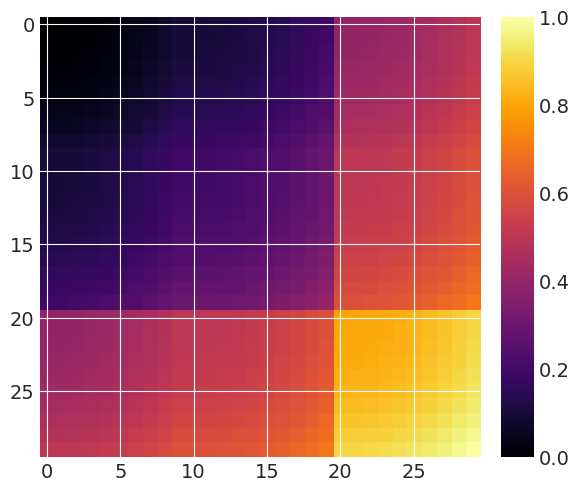

In [124]:
# Plot of X2, which is t
plt.imshow((tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))).eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);

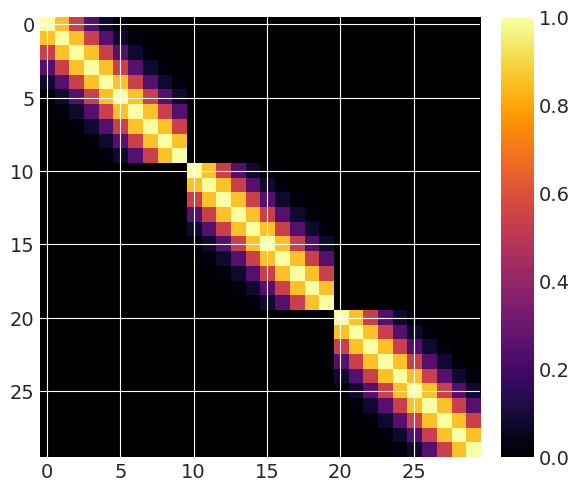

In [125]:
plt.imshow(tt.exp(-0.5 * sqd).eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);

This is not super interesting in the sense that we can arbitrary make the series super independent (then it just doesn't make sense to build such a big matrix) or closer together. But again, when they are closer, the independence is also always stronger in the series that are closer together. This does not make sense, because the order in which we add the series to model will change completely the outcome of the analysis.

# Exploration of the Coregionalization model

https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550

https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

In [61]:
%pylab inline
import pylab as pb
pylab.ion()
import GPy

Populating the interactive namespace from numpy and matplotlib


/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['add', 'ylim', 'cov', 'xlim', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [62]:
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2
f_output2 = lambda x: 6. * np.cos(x/5) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.

# {X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
# {X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

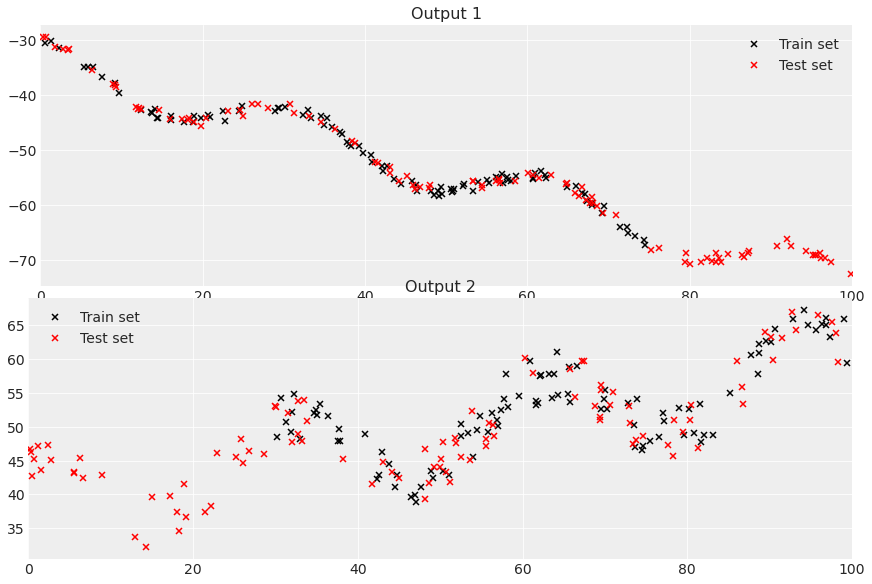

In [63]:
xlim = (0,100); ylim = (0,50)
fig = pb.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend();

In [194]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

The coregionalized regression model relies on the use of multiple output kernels or vector-valued kernels, of the following form:

$$\begin{align*}
{\bf B}\otimes{\bf K} = 
\left(\begin{array}{ccc}
B_{1,1}\times{\bf K}({\bf X}_{1}, {\bf X}_{1}) & \ldots &
B_{1,D}\times{\bf K}({\bf X}_{1}, {\bf X}_{D}\\
\vdots & \ddots\\
B_{D, 1}\times{\bf K}({\bf X}_{D}, {\bf X}_{1}) & \ldots &
B_{D, D}\times{\bf K}({\bf X}_{D}, {\bf X}_{D})
\end{array}\right)
\end{align*}$$

In the expression above, $\bf{K}$ is a kernel function, $\bf{B}$ is regarded as the coregionalization matrix, and $\bf{X}_i$ represents the inputs corresponding to the $i$-th output. 

In GPy, a multiple output kernel is defined in the following way.

In [186]:
import GPy
K = GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1, output_dim=2)
multkernel = K.prod(B, name='B.K')
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


The components of the kernel can be accessed as follows:

In [187]:
# Components of B
print('W matrix\n', B.W)
print('\nkappa vector\n', B.kappa)
print('\nB matrix\n', B.B)

W matrix
   index  |   coregion.W  |  constraints  |  priors
  [0 0]  |  -0.28189437  |               |        
  [1 0]  |   0.04484320  |               |        

kappa vector
   index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        

B matrix
 [[ 0.57946443 -0.01264105]
 [-0.01264105  0.50201091]]


Once we have defined an appropriate kernel for our model, its use is straightforward. In the next example we will use a Matern-3/2 kernel as K.


Name : gp
Objective : 373.9350987124531
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |               value  |  constraints  |  priors
  ICM.Mat32.variance                     |                 1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |  231.17222409905062  |      +ve      |        
  ICM.B.W                                |              (2, 1)  |               |        
  ICM.B.kappa                            |                (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.3515819170868043  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |   4.990763989671759  |      +ve      |        


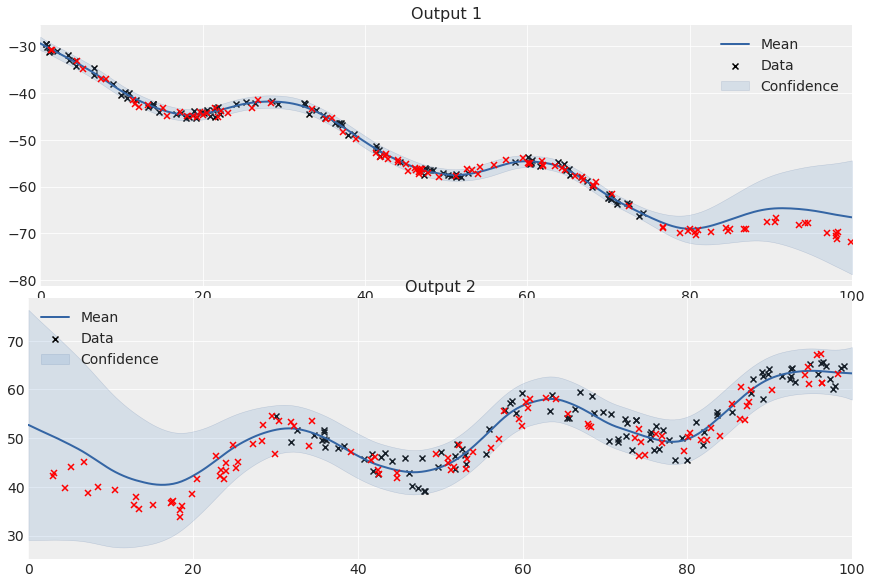

In [195]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2], kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.)
m.optimize()
print(m)
plot_2outputs(m, xlim=(0, 100), ylim=(-20, 60))

Notice that there are two parameters for the noise variance. Each one corresponds to the noise of each output.

But what is the advantage of this model? Well, the fit of a non-coregionalized model (i.e. two independent models) would look like

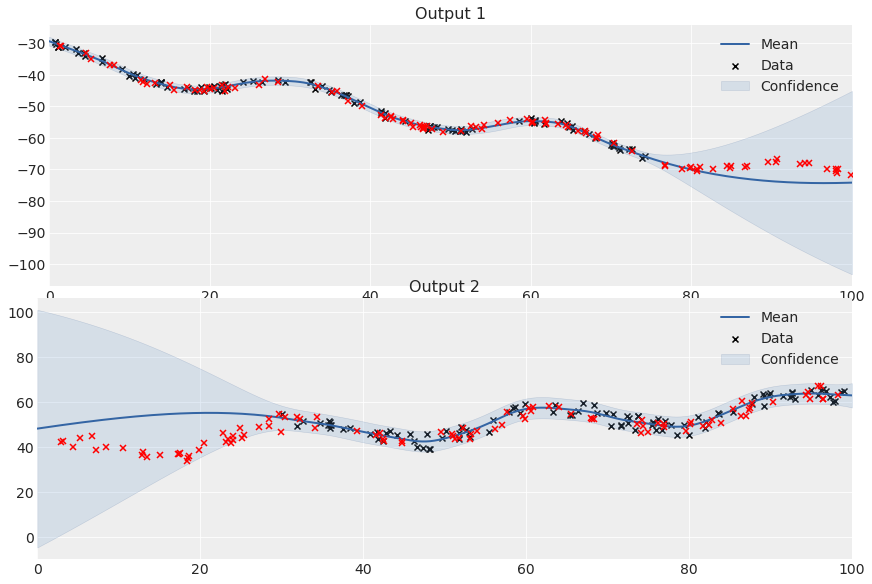

In [196]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2');

The coregionalized model shares information across outputs, but the independent models cannot do that. In the regions where there is no training data specific to an output the independent models tend to return to the prior assumptions. In this case, where both outputs have associated patterns, the fit is better with the coregionalized model.

Can we improve the fit in the coregionalization? Yes, we will have a look at that in the next section.

##### Kernel selection

The data from both outputs is not centered on zero. A way of dealing with outputs of different means or magnitudes is using a bias kernel.

This kernel is just changing the mean (constant) of the Gaussian Process being fitted. There is no need to assume any sort of correlation between both means, so we define W=0.

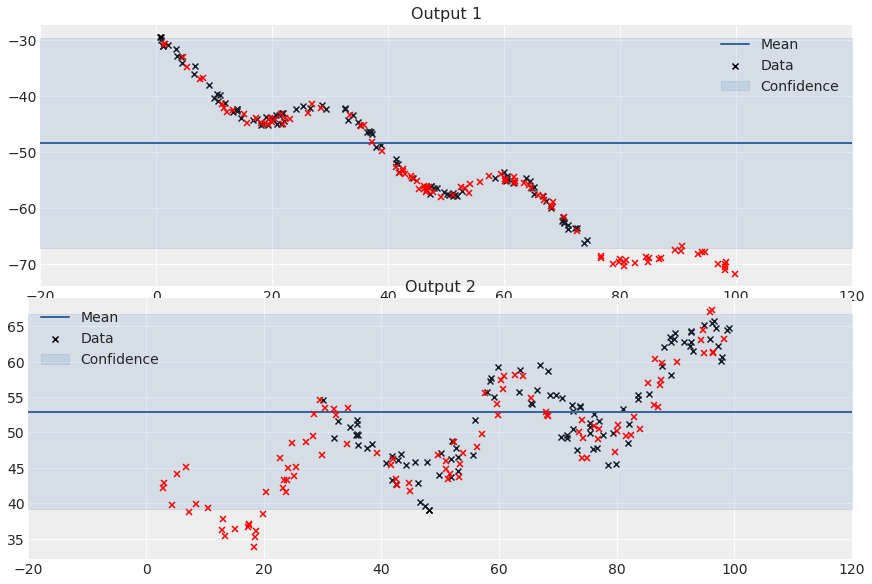

In [197]:
kernel = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.Bias(input_dim=1))
m = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2],Y_list=[Y1,Y2],kernel=kernel)
m['.*bias.var'].constrain_fixed(1) #B.kappa now encodes the variance.
m['.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

At the moment, our model is only able to explain the mean of the data. However we can notice that there is a decreasing trend in the first output and increasing trend in the second one. In this case we can model such a trend with a linear kernel.

Since the linear kernel only fits a line with constant slope along the output space, there is no need to assume any correlation between outpus. 

We could define our new multiple output kernel as follows:

$${\bf K}_{ICM} = {\bf B} \otimes ({\bf K}_{bias} + {\bf K}_{linear})$$

However, we can also define a more general kernel of the following form:

$${\bf K}_{LCM} = {\bf B}_1 \otimes {\bf K}_{bias} + {\bf B}_2 \otimes {\bf K}_{linear}$$

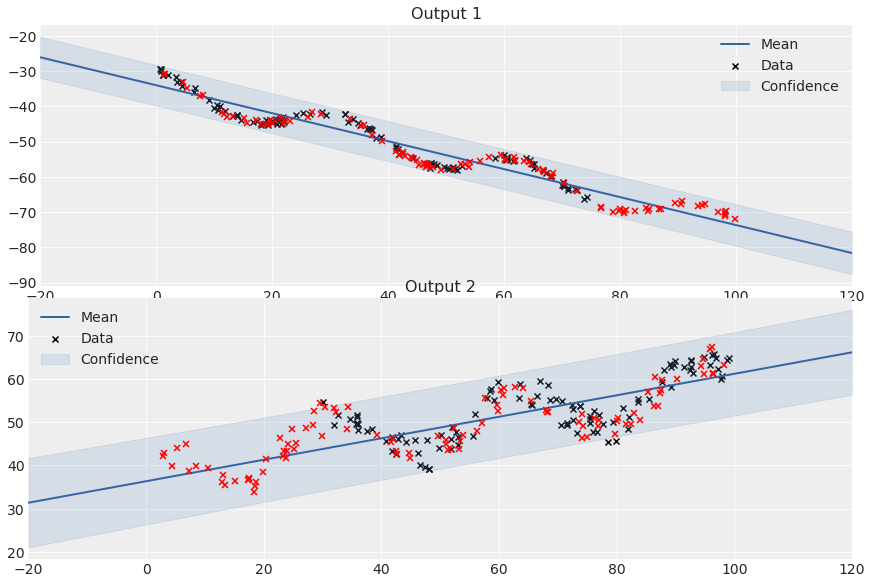

In [198]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()
plot_2outputs(m, xlim=(-20, 120), ylim=(0,60))

Now we will model the variation along the trend defined by the linear component. We will do this with a Matern-3/2 kernel.

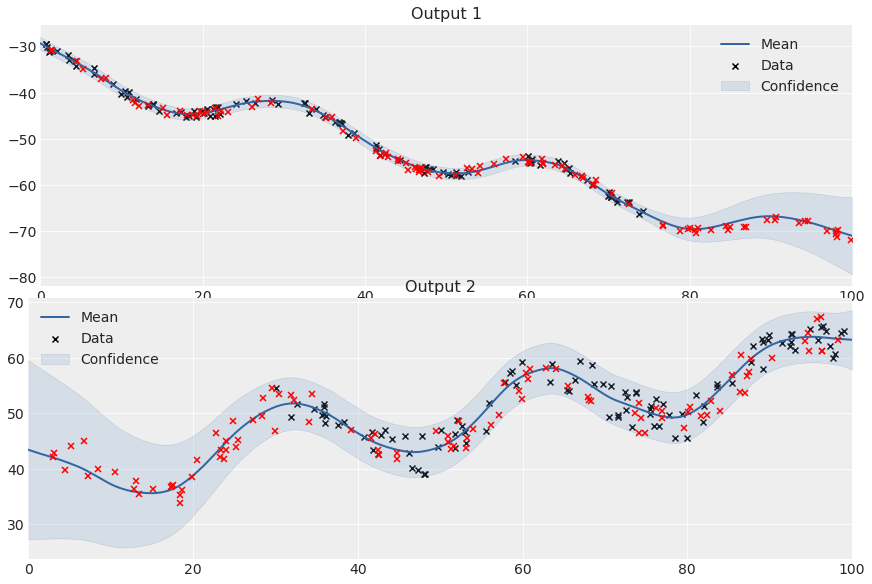

In [199]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K1, K2, K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

### Using PyMC3

### generate and then plot the data

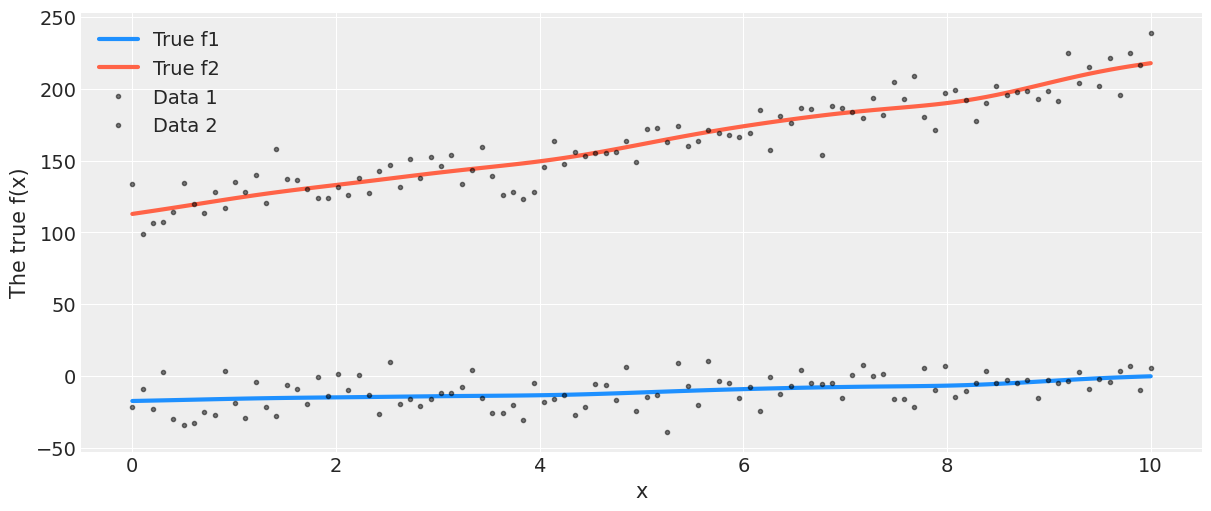

In [28]:
# set the seed
np.random.seed(1)

n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
l_true1 = 1.0
eta_true1 = 2.0
l_true2 = 10.0
eta_true2 = 6.0
cov_func1 = eta_true1**2 * pm.gp.cov.ExpQuad(1, l_true1) 
cov_func2 = eta_true2**2 * pm.gp.cov.ExpQuad(1, l_true2)

mean_func1 = pm.gp.mean.Linear(10, 100)
mean_func2 = pm.gp.mean.Constant(25)

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func1(x).eval(),
                                        cov_func1(x).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func2(x).eval(),
                                        cov_func2(x).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 10.0
f1 = 0.3*f_true1 - 2.0*f_true2
f2 = 1.0*f_true1 + 0.5*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

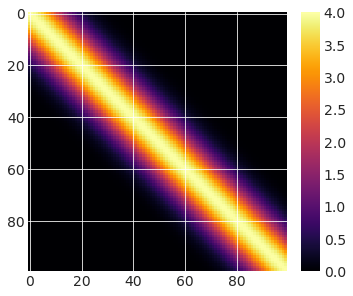

In [76]:
m = plt.imshow(cov_func1(x).eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);

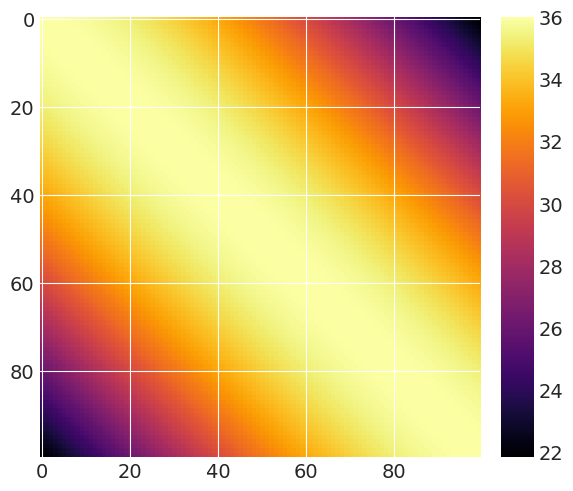

In [30]:
m = plt.imshow(cov_func2(x).eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);

In [31]:
mean_func1(x).eval()

array([100.        , 101.01010101, 102.02020202, 103.03030303,
       104.04040404, 105.05050505, 106.06060606, 107.07070707,
       108.08080808, 109.09090909, 110.1010101 , 111.11111111,
       112.12121212, 113.13131313, 114.14141414, 115.15151515,
       116.16161616, 117.17171717, 118.18181818, 119.19191919,
       120.2020202 , 121.21212121, 122.22222222, 123.23232323,
       124.24242424, 125.25252525, 126.26262626, 127.27272727,
       128.28282828, 129.29292929, 130.3030303 , 131.31313131,
       132.32323232, 133.33333333, 134.34343434, 135.35353535,
       136.36363636, 137.37373737, 138.38383838, 139.39393939,
       140.4040404 , 141.41414141, 142.42424242, 143.43434343,
       144.44444444, 145.45454545, 146.46464646, 147.47474747,
       148.48484848, 149.49494949, 150.50505051, 151.51515152,
       152.52525253, 153.53535354, 154.54545455, 155.55555556,
       156.56565657, 157.57575758, 158.58585859, 159.5959596 ,
       160.60606061, 161.61616162, 162.62626263, 163.63

In [32]:
mean_func2(x).eval()

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25.], dtype=float32)

### Format the data for the coregionalized GP

In [33]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

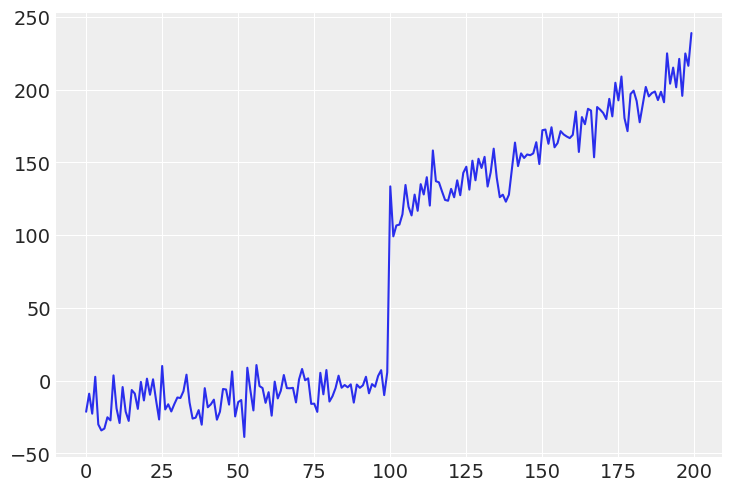

In [8]:
plt.plot(y);

### pymc3 model

In [9]:
# Implementing Coregion

W = np.random.normal(loc=0, scale=1, size=(2,2))
kappa = stats.gamma.rvs(a=2, size=2)

W = tt.as_tensor_variable(W)
kappa = tt.as_tensor_variable(kappa)
B = tt.dot(W, W.T) + tt.diag(kappa)

B.eval()

array([[ 2.89105944, -0.38563145],
       [-0.38563145,  3.43570194]])

In [10]:
index = tt.cast(X[:,1], "int32")[:,None]
index2 = index.T
B = B[index, index2]

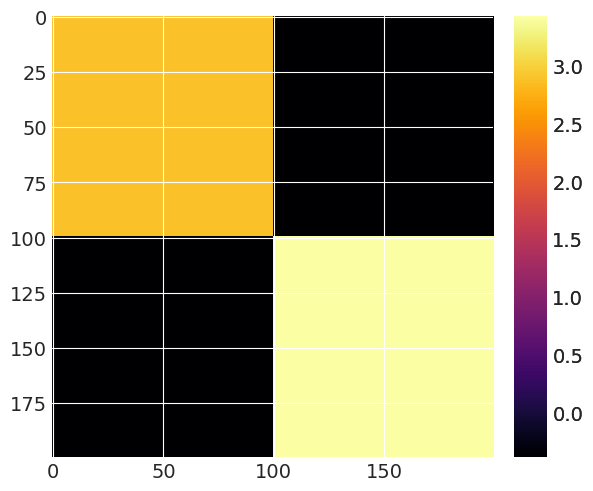

In [11]:
m = plt.imshow(B.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

In [12]:
# Implementing the ExpQuad for two dimensions
ls = stats.gamma.rvs(a=2)
ls = tt.as_tensor_variable(ls)

X_ = tt.mul(X, 1.0 / ls)
X2 = tt.sum(tt.square(X_), 1)

sqd = -2.0 * tt.dot(X_, tt.transpose(X_)) + (
        tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))
    )

cov = tt.exp(-0.5 * sqd)
cov.eval().shape

(200, 200)

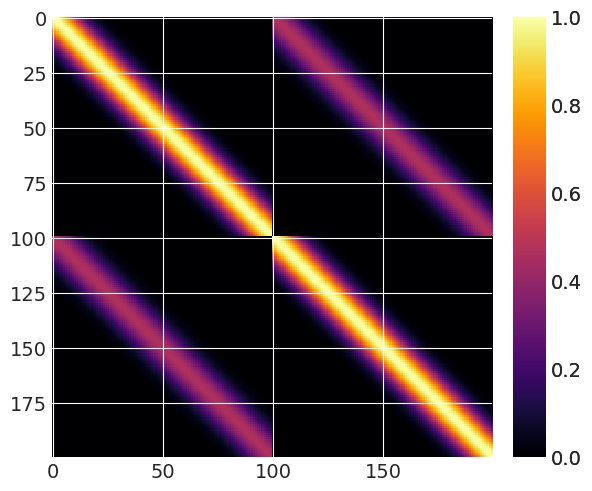

In [13]:
m = plt.imshow(cov.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

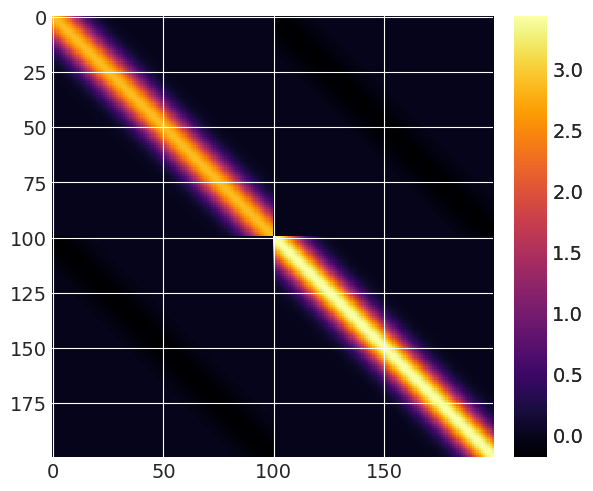

In [14]:
# Multiplication between Cov and Coregion

coreg = B * cov

m = plt.imshow(coreg.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

In [15]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ls = pm.Gamma("ls", alpha=2, beta=0.5)
    #cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    # Implementing the ExpQuad for two dimensions
    ls = tt.as_tensor_variable(ls)
    X_ = tt.mul(X, 1.0 / ls)
    X2 = tt.sum(tt.square(X_), 1)

    sqd = -2.0 * tt.dot(X_, tt.transpose(X_)) + (
            tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))
        )
    cov = eta**2 * tt.exp(-0.5 * sqd)
    
    # Implementing Coregion
    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    

    W = tt.as_tensor_variable(W)
    kappa = tt.as_tensor_variable(kappa)
    B = tt.dot(W, W.T) + tt.diag(kappa)
    
    index = tt.cast(X[:,1], "int32")[:,None]
    index2 = index.T
    B = B[index, index2]
    
    #coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = B * cov

    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    #y_ = marginal_likelihood("f", X,cov_func, y, noise=sigma) 

In [18]:
n = 100
s = 2

In [19]:
n_series_idx = np.repeat(np.arange(s), n)

### Custom Linear function for two output GP

In [20]:
class Mean:
    R"""
    Base class for mean functions
    """

    def __call__(self, X):
        R"""
        Evaluate the mean function.
        Parameters
        ----------
        X: The training inputs to the mean function.
        """
        raise NotImplementedError

    def __add__(self, other):
        return Add(self, other)

    def __mul__(self, other):
        return Prod(self, other)

class Linear(Mean):
    R"""
    Linear mean function for Gaussian process.
    Parameters
    ----------
    coeffs: variables
        Linear coefficients
    intercept: variable, array or integer
        Intercept for linear function (Defaults to zero)
    """

    def __init__(self, coeffs, intercept=0):
        Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        X = theano.shared(X)
        return tt.flatten(((X[:,0].reshape((2,-1)).T * self.A.reshape((1,-1))) + self.b.reshape((1,-1))).T)

In [21]:
beta = np.random.randn(2)
b = np.random.randn(2)
X = np.random.randn(10, 2)

In [22]:
lin_func = Linear(coeffs=beta, intercept=b)

print(lin_func(X).eval())

[1.01943301 0.26745879 0.6542533  0.41151831 0.62926498 1.23959137
 2.48686908 2.92577276 0.93958115 1.14334687]


In [23]:
X

array([[ 0.45128402, -1.68405999],
       [-1.1601701 ,  1.35010682],
       [-0.33128317,  0.38653915],
       [-0.85145566,  1.00088142],
       [-0.38483225,  1.45810824],
       [-0.53223402,  1.1181334 ],
       [ 0.6743961 , -0.72239191],
       [ 1.09899633, -0.90163449],
       [-0.82246719,  0.72171129],
       [-0.625342  , -0.59384307]])

In [24]:
X[:,0].reshape((2,-1)).T * beta.reshape((1,-1)) + b.reshape((1,-1))

array([[1.01943301, 1.23959137],
       [0.26745879, 2.48686908],
       [0.6542533 , 2.92577276],
       [0.41151831, 0.93958115],
       [0.62926498, 1.14334687]])

Elementwise multiplication of the column 0 of X (has the time for each series) with the slope for each series and sum of the intercept

In [25]:
(X[:,0].reshape((2,-1)).T * beta.reshape((1,-1)) + b.reshape((1,-1))).ravel('F')

array([1.01943301, 0.26745879, 0.6542533 , 0.41151831, 0.62926498,
       1.23959137, 2.48686908, 2.92577276, 0.93958115, 1.14334687])

### Model

In [34]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    beta = pm.Normal('beta', mu=0,sigma=2, shape=2)
    a = pm.Normal('a', mu=0,sigma=100, shape=2)

    lin_func = Linear(coeffs=beta, intercept=a)
    
    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func = lin_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

### MAP estimate and generate some predictions

In [35]:
with model:
    mp = pm.find_MAP()

x_new = np.linspace(0, 20, 200)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    f_pred = gp.conditional("f_pred", X_new)

In [36]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

### Checking the cov matrix

In [37]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'f'])]}]

In [38]:
mp_list

[{'W': array([[-0.28925812,  0.53593027],
         [-1.88733863,  3.49608155]]),
  'beta': array([0.96490116, 4.96545305]),
  'a': array([-14.86670183, 139.89209736]),
  'eta': array(3.95279212),
  'ell': array(4.8334763),
  'kappa': array([0.10580914, 0.48414609]),
  'sigma': array(10.30714217)}]

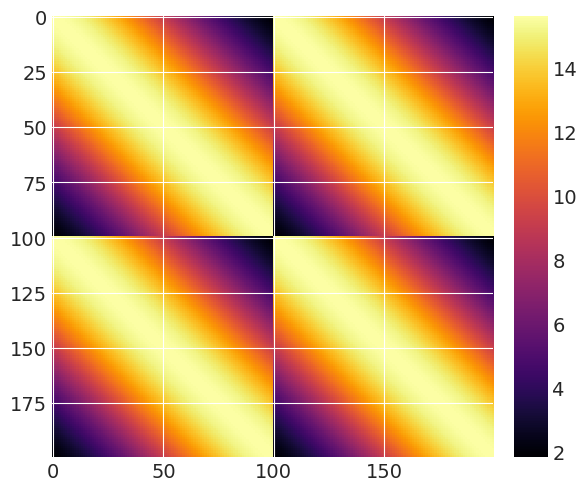

In [39]:
# Regular cov matrix

eta = mp_list[0]['eta']
ell = mp_list[0]['ell']

# Cov func
cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])

K = cov_func(X).eval()
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

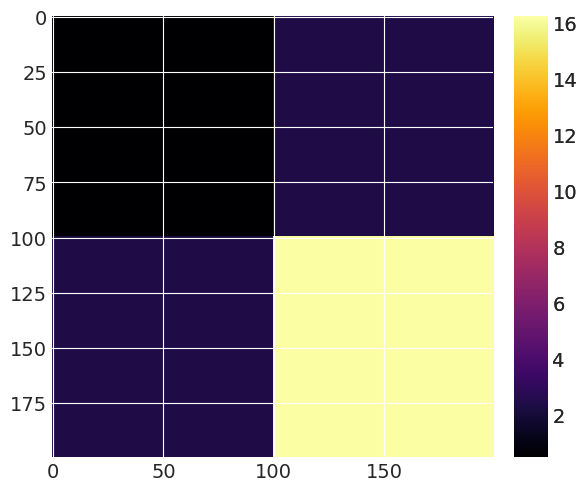

In [40]:
# Coregion

W = mp_list[0]['W']
kappa = mp_list[0]['kappa']

W = tt.as_tensor_variable(W)
kappa = tt.as_tensor_variable(kappa)
B = tt.dot(W, W.T) + tt.diag(kappa)

index = tt.cast(X[:,1], "int32")[:,None]
index2 = index.T
B = B[index, index2]

m = plt.imshow(B.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

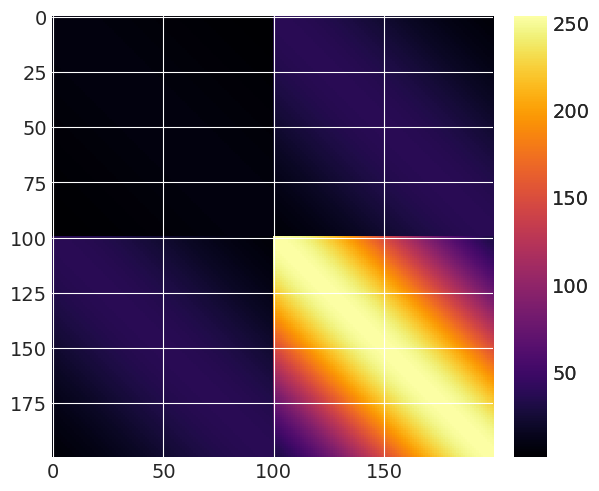

In [41]:
# Multiplication between Cov and Coregion

coreg_test = B * K

m = plt.imshow(coreg_test.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

### Plot

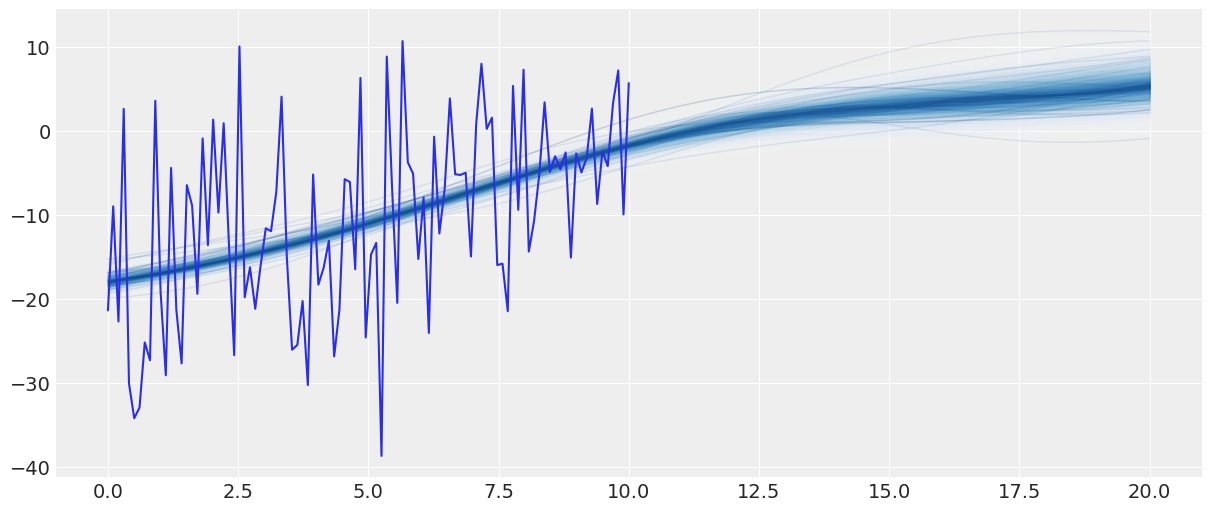

In [42]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, pred_samples['f_pred'][:, :200], X_new[:200,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.linspace(0,10,100),y[0:100]);

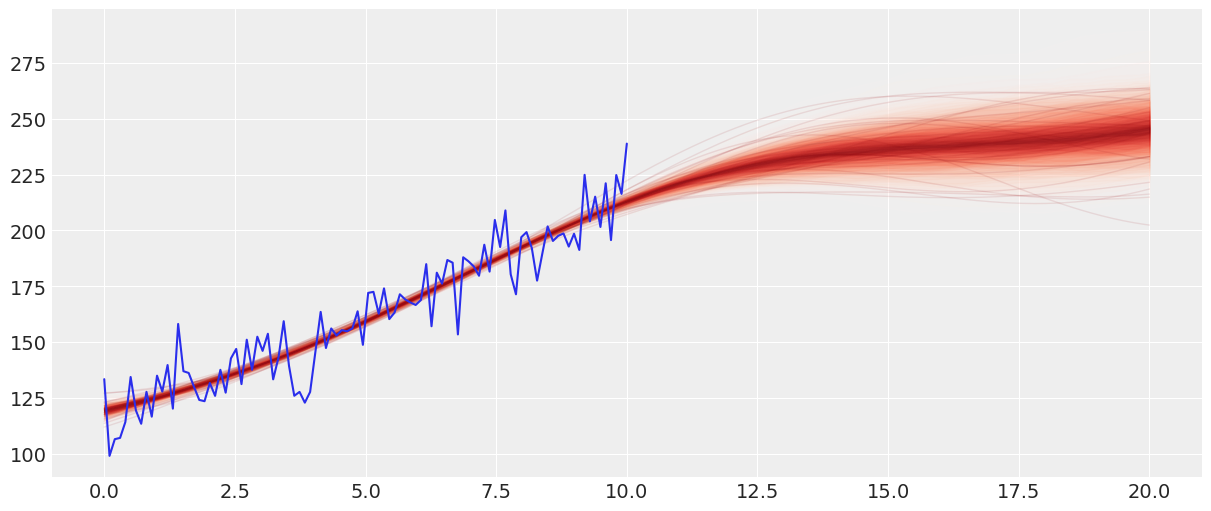

In [43]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 200:], X_new[200:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.linspace(0,10,100),y[100:200]);

# Without coregional and without mean function

In [45]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    #beta = pm.Normal('beta', mu=0,sigma=1, shape=2)
    #a = pm.Normal('a', mu=0,sigma=1, shape=1)
    mean_func = pm.gp.mean.Zero()

    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


In [46]:
with model:
    mp = pm.find_MAP()

x_new = np.linspace(0, 20, 200)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [47]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"
/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


In [48]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

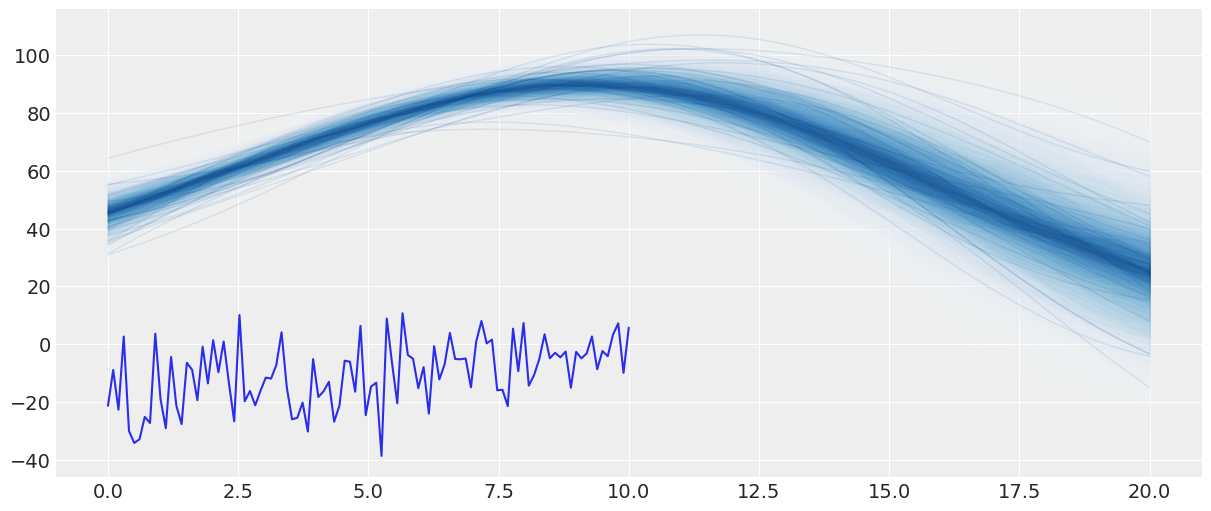

In [49]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 200:], X_new[200:,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.linspace(0,10,100),y[0:100]);

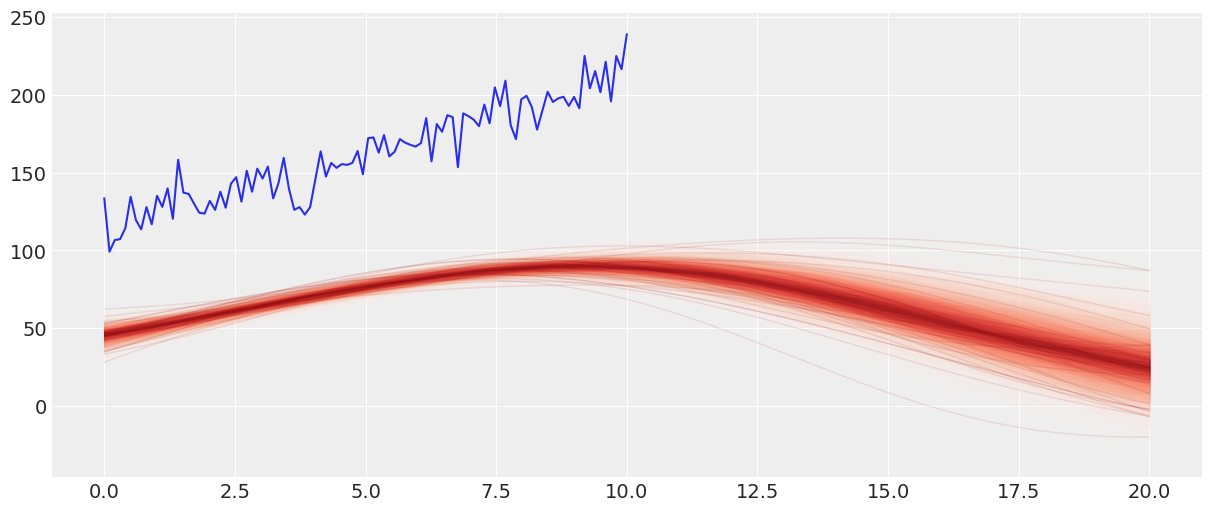

In [50]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 200:], X_new[200:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.linspace(0,10,100),y[100:200]);

# Without coregional

In [51]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    beta = pm.Normal('beta', mu=0,sigma=10, shape=2)
    a = pm.Normal('a', mu=0,sigma=100, shape=2)

    lin_func = Linear(coeffs=beta, intercept=a)
    
    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func=lin_func, cov_func=cov)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


In [52]:
with model:
    mp = pm.find_MAP()

x_new = np.linspace(0, 20, 200)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [53]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'f'])]}]

In [54]:
mp_list

[{'beta': array([ 1.79698922, 10.07119112]),
  'a': array([-19.2508063 , 112.13147156]),
  'eta': array(2.36951655),
  'ell': array(0.67613842),
  'sigma': array(10.05482705)}]

In [55]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/gp/cov.py:90: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"


In [56]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

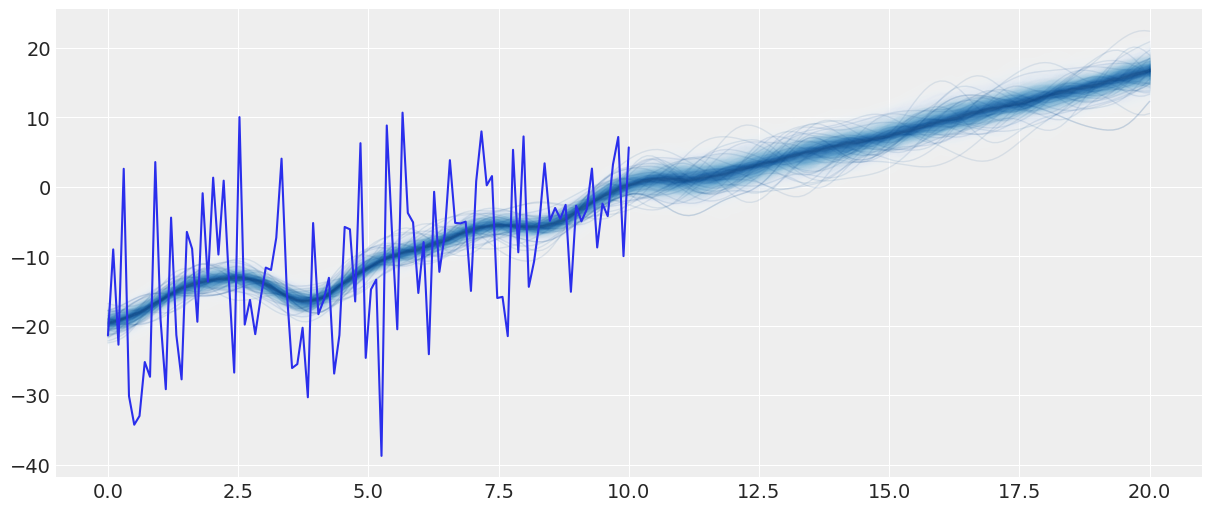

In [57]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, pred_samples['f_pred'][:, :200], X_new[:200,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.linspace(0,10,100),y[0:100]);

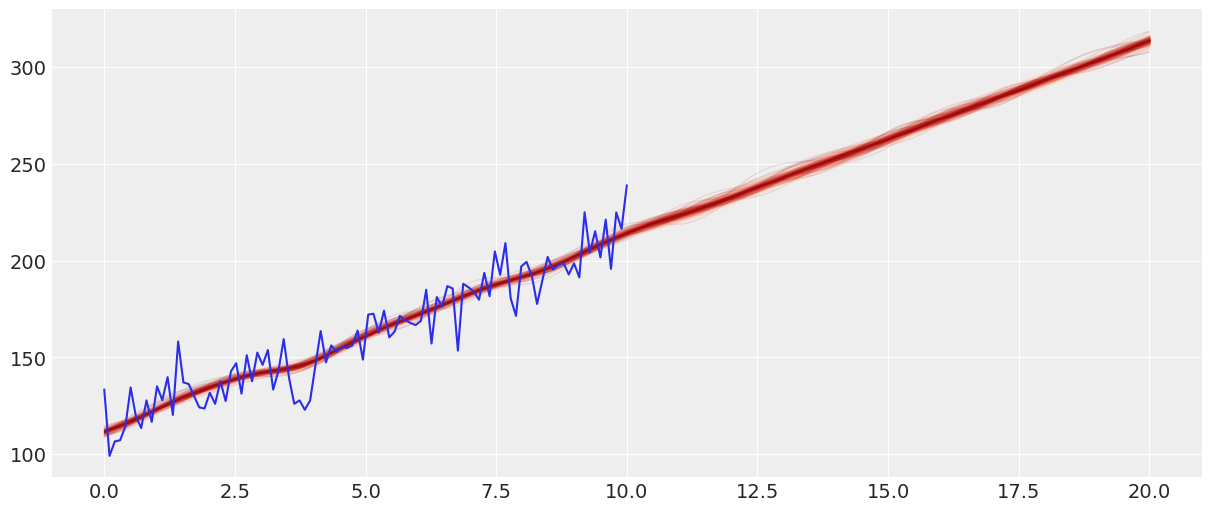

In [58]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 200:], X_new[200:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.linspace(0,10,100),y[100:200]);

# Another example

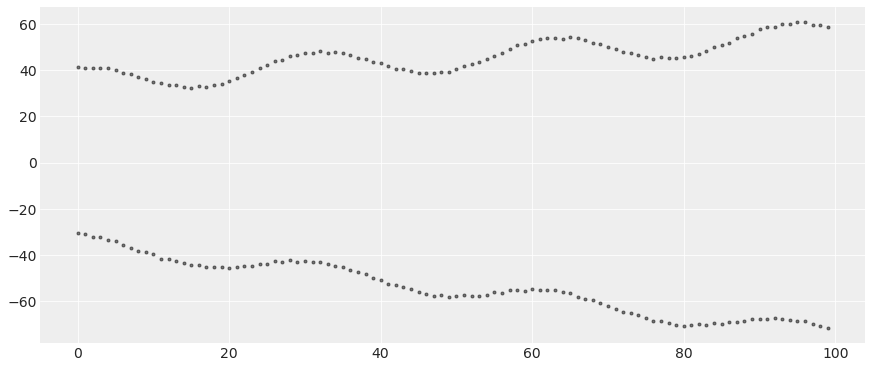

In [89]:
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)
f_output2 = lambda x: 6. * np.cos(x/5) + .2*x + 35. + np.random.rand(x.size)

# {X,Y} training set for each output
x = np.arange(100)

y1 = f_output1(x)
y2 = f_output2(x)
x = x[:, None] 

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

### Format the data for the coregionalized GP

In [91]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

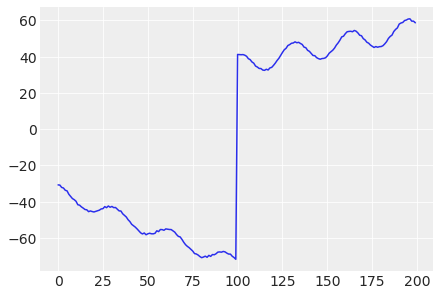

In [92]:
plt.plot(y);

### Model

In [211]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    beta = pm.Normal('beta', mu=0,sigma=2, shape=2)
    a = pm.Normal('a', mu=0,sigma=100, shape=2)

    lin_func = Linear(coeffs=beta, intercept=a)
    
    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func = lin_func, cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

### MAP estimate and generate some predictions

In [212]:
with model:
    mp = pm.find_MAP()

x_new = np.arange(120)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(120), np.ones(120)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    f_pred = gp.conditional("f_pred", X_new)

In [213]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

### Checking the cov matrix

In [214]:
mp_list = [{key: mp.get(key) for key in [i for i in mp]}]

In [215]:
mp_list

[{'eta_log__': array(0.27143367),
  'ell_log__': array(2.5744641),
  'W': array([[ 1.9426951 , -1.00236616],
         [ 2.97419278, -1.5344553 ]]),
  'kappa_log__': array([-6.68865235, -5.80041569]),
  'beta': array([-0.41358396,  0.17659959]),
  'a': array([-33.2038738 ,  37.60547177]),
  'sigma_log__': array(-1.24922852),
  'eta': array(1.31184386),
  'ell': array(13.12428203),
  'kappa': array([0.00124496, 0.0030263 ]),
  'sigma': array(0.28672591)}]

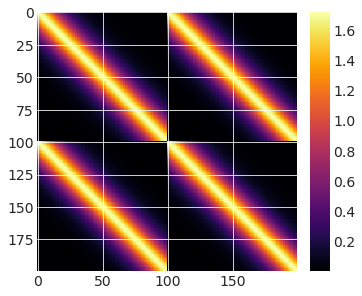

In [216]:
# Regular cov matrix

eta = mp_list[0]['eta']
ell = mp_list[0]['ell']

# Cov func
cov_func = eta**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell, active_dims=[0])

K = cov_func(X).eval()
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

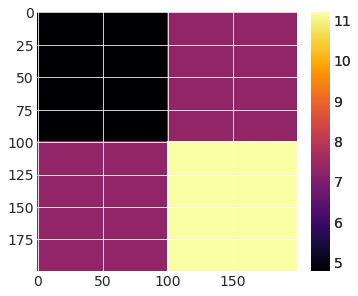

In [217]:
# Coregion

W = mp_list[0]['W']
kappa = mp_list[0]['kappa']

W = tt.as_tensor_variable(W)
kappa = tt.as_tensor_variable(kappa)
B = tt.dot(W, W.T) + tt.diag(kappa)

index = tt.cast(X[:,1], "int32")[:,None]
index2 = index.T
B = B[index, index2]

m = plt.imshow(B.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

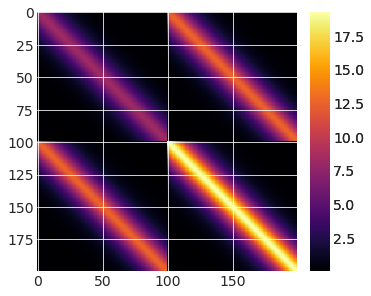

In [218]:
# Multiplication between Cov and Coregion

coreg_test = B * K

m = plt.imshow(coreg_test.eval(), cmap="inferno", interpolation='none'); plt.colorbar(m);
plt.colorbar(m);

### Plot

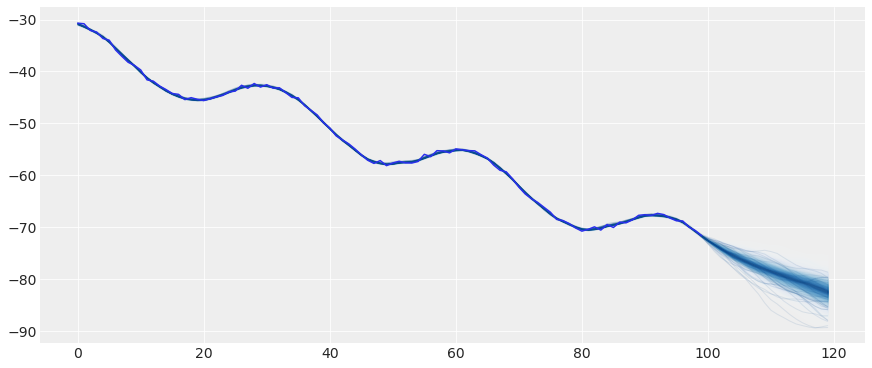

In [219]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, pred_samples['f_pred'][:,:120], X_new[:120,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(100),y[0:100]);

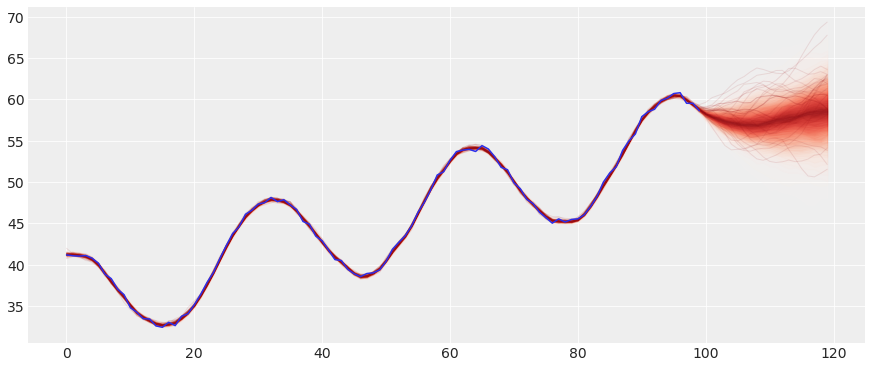

In [220]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 120:], X_new[120:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.arange(100),y[100:200]);

# Without coregional

In [221]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=5, beta=0.5)
    ell = pm.Gamma("ell", alpha=5, beta=0.5)
    cov = eta**2 * pm.gp.cov.Matern32(2, ls=ell, active_dims=[0])
    
    beta = pm.Normal('beta', mu=0,sigma=10, shape=2)
    a = pm.Normal('a', mu=0,sigma=100, shape=2)

    lin_func = Linear(coeffs=beta, intercept=a)
    
    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func=lin_func, cov_func=cov)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

In [222]:
with model:
    mp = pm.find_MAP()

x_new = np.arange(120)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(120), np.ones(120)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [223]:
mp_list = [{key: mp.get(key) for key in [i for i in mp]}]

In [178]:
mp_list

[{'eta_log__': array(-9.69573532),
  'ell_log__': array(-9.58853126),
  'beta': array([-0.44547948,  0.3065706 ]),
  'a': array([-31.08468829,  31.37846291]),
  'sigma_log__': array(1.58046987),
  'eta': array(6.15454076e-05),
  'ell': array(6.85099711e-05),
  'sigma': array(4.85723754)}]

In [180]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

In [181]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

In [189]:
pred_samples['f_pred'].T.shape

(240, 300)

In [196]:
pred_samples['f_pred'][:,:120].shape

(300, 120)

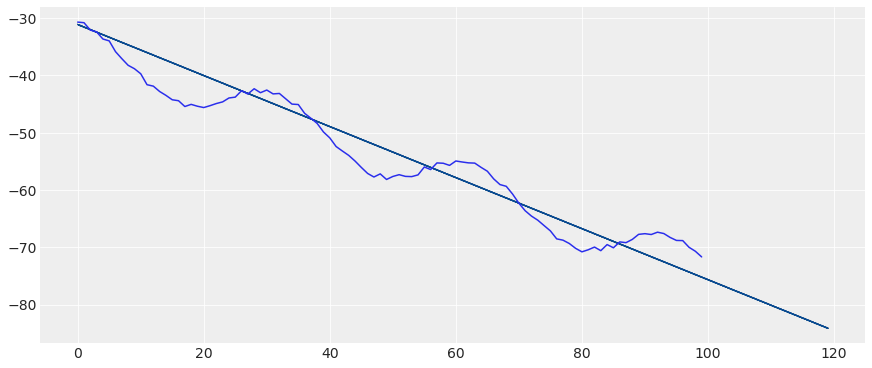

In [198]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, pred_samples['f_pred'][:,:120], X_new[:120,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(100),y[0:100]);

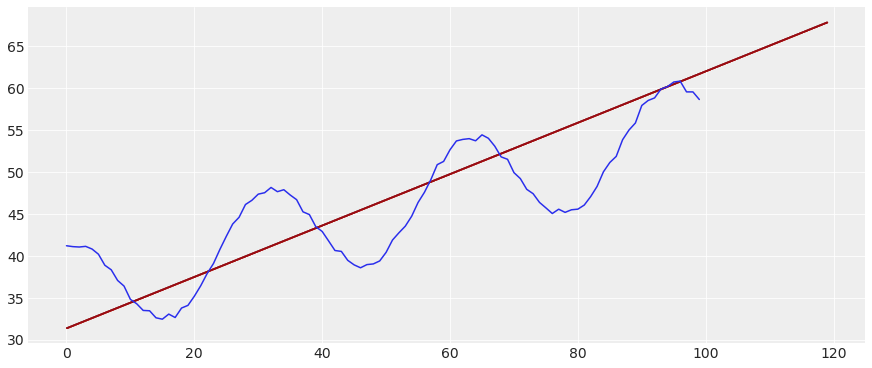

In [199]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 120:], X_new[120:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.arange(100),y[100:200]);

# Without coregional and without mean function

In [224]:
with pm.Model() as model:
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.Matern32(2, ls=ell, active_dims=[0])
    
    #beta = pm.Normal('beta', mu=0,sigma=1, shape=2)
    #a = pm.Normal('a', mu=0,sigma=1, shape=1)
    mean_func = pm.gp.mean.Zero()

    sigma = pm.HalfNormal("sigma", sd=3)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma) 

In [225]:
with model:
    mp = pm.find_MAP()

x_new = np.arange(120)[:,None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(120), np.ones(120)))[:,None]
X_new = np.concatenate((xx_new, idx2), axis=1)

INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.3--generic-x86_64-with-glibc2.10-x86_64-3.8.2-64/lock_dir/lock


In [226]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

In [227]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=300)

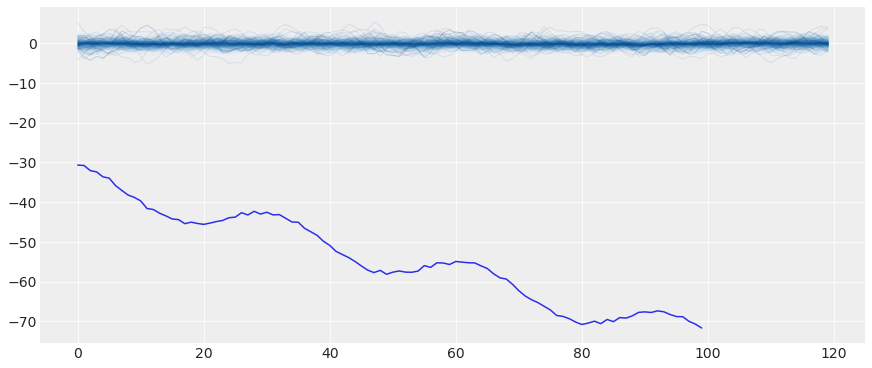

In [229]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, pred_samples['f_pred'][:,:120], X_new[:120,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(100),y[0:100]);

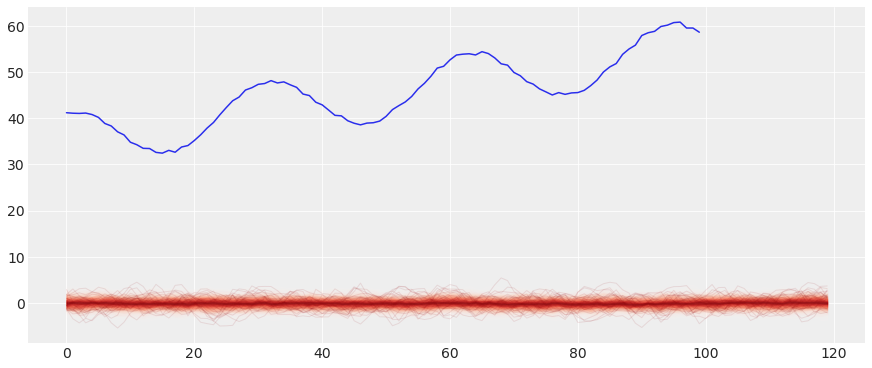

In [228]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples['f_pred'][:, 120:], X_new[120:,0], palette="Reds", fill_alpha=0.1, samples_alpha=0.1)
plt.plot(np.arange(100),y[100:200]);